In [184]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
from pyro.infer.inspect import get_dependencies
import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
import arviz as az
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

[ 0  1 10 11 12 13 14]
[0 1 2 3 4 5 6]
(83, 86)


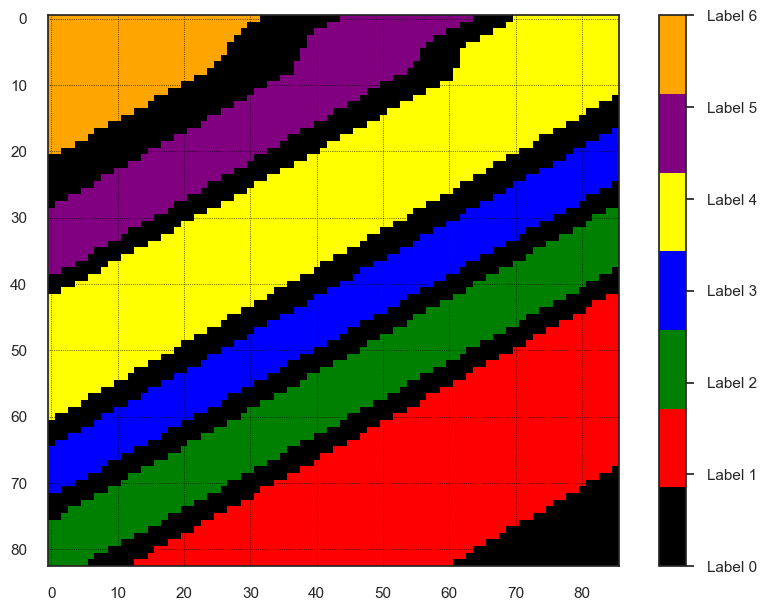

[[6 6 6 ... 4 4 4]
 [6 6 6 ... 4 4 4]
 [6 6 6 ... 4 4 4]
 ...
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]]


In [185]:
import scipy.io

# Load .mat file
SalinasA= np.array(scipy.io.loadmat('SalinasA.mat')['salinasA'])
SalinasA_corrected= np.array(scipy.io.loadmat('SalinasA_corrected.mat')['salinasA_corrected'])
SalinasA_gt= np.array(scipy.io.loadmat('SalinasA_gt.mat')['salinasA_gt'])

i=0
label_data = [0,6,1,5,4,3,2]
print(np.unique(SalinasA_gt))
for ele in np.unique(SalinasA_gt):
    #print(ele)
    mask = SalinasA_gt==ele
    SalinasA_gt[mask] = label_data[i]
    #print(SalinasA_gt)
    i=i+1
    #print(i+1)
print(np.unique(SalinasA_gt))

print(SalinasA_gt.shape)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Define a colormap with colors for each label
colors = ['black', 'red', 'green', 'blue', 'yellow', 'purple', 'orange']
cmap = ListedColormap(colors)

plt.imshow(SalinasA_gt, cmap=cmap, vmin=0, vmax=len(colors)-1)

# Add colorbar to show label-color mapping
cbar = plt.colorbar(ticks=np.arange(len(colors)))
cbar.set_ticklabels([f'Label {i}' for i in range(len(colors))])
# Add a label at a specific coordinate (e.g., x=5, y=5)
#label_text = "A"
#plt.text(20, 10, label_text, color='red', fontsize=4, ha='center', va='center')
# Set ticks to align with individual pixels
#plt.xticks(np.arange(0.0, 87.0, 1), [])
#plt.yticks(np.arange(0.0, 84.0, 1), [])
plt.grid(True, which='both', color='black', linewidth=0.5, linestyle=':')
plt.show()
print(SalinasA_gt)

In [186]:
SalinasA_gt.shape, SalinasA_corrected.shape

((83, 86), (83, 86, 204))

In [187]:
column = 20
y_obs = torch.tensor(SalinasA_gt[:,column], dtype=torch.float64)
mask = y_obs!=0
print(mask)
y_obs_label = y_obs[mask]
print(len(y_obs_label))
print(SalinasA_corrected.shape)
y_obs_hsi = torch.tensor(SalinasA_corrected[:,column,:], dtype=torch.float64)[mask]
y_obs_hsi.shape

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False,  True,  True,
         True,  True,  True])
59
(83, 86, 204)


torch.Size([59, 204])

In [188]:
y_obs_hsi

tensor([[376., 481., 731.,  ...,   2.,   0.,   0.],
        [363., 493., 684.,  ...,   6.,   1.,   0.],
        [363., 493., 684.,  ...,   6.,   1.,   0.],
        ...,
        [376., 392., 599.,  ...,  30.,  12.,  19.],
        [294., 307., 597.,  ...,  33.,  13.,  21.],
        [294., 307., 597.,  ...,  33.,  13.,  21.]], dtype=torch.float64)

In [189]:
from scipy.stats import zscore

In [190]:
normalised_hsi = zscore(y_obs_hsi, axis=0)
normalised_hsi

tensor([[-0.0917, -0.1022,  0.6458,  ..., -2.0414, -2.0789, -2.1446],
        [-0.3896,  0.0792, -0.0924,  ..., -1.8319, -1.9459, -2.1446],
        [-0.3896,  0.0792, -0.0924,  ..., -1.8319, -1.9459, -2.1446],
        ...,
        [-0.0917, -1.4476, -1.4273,  ..., -0.5751, -0.4825, -0.4311],
        [-1.9709, -2.7326, -1.4587,  ..., -0.4180, -0.3495, -0.2507],
        [-1.9709, -2.7326, -1.4587,  ..., -0.4180, -0.3495, -0.2507]],
       dtype=torch.float64)

In [191]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
transformed_hsi = model.fit_transform(normalised_hsi) 

In [192]:
transformed_hsi.shape

(59, 2)

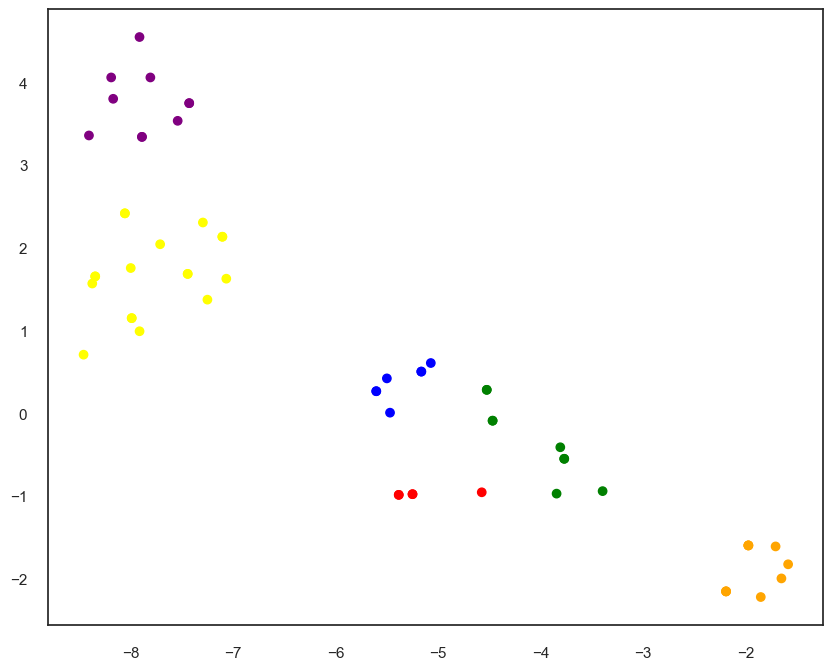

In [193]:
plt.figure(figsize=(10,8))
plt.scatter(transformed_hsi[:,0],transformed_hsi[:,1],c=y_obs_label, cmap=ListedColormap(colors[1:]))


In [194]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [195]:
gm =gm = BayesianGaussianMixture(n_components=6, random_state=0).fit(normalised_hsi)


In [196]:
gm.means_ , gm.covariances_

(array([[ 0.12906035,  0.1155815 ,  0.33734788, ...,  0.77531731,
          0.76816842,  0.84472794],
        [ 0.18750484,  0.28361056, -0.45802284, ..., -1.67492865,
         -1.66013405, -1.68724715],
        [-0.48508197,  0.38624935, -0.18674731, ...,  0.13609434,
          0.28936361, -0.0193617 ],
        [ 0.77918679, -0.00223609,  1.17668411, ...,  0.73870179,
          0.5167549 ,  0.60836502],
        [-0.71043501, -1.38776467, -1.20770212, ..., -0.51419992,
         -0.33558663, -0.44939526],
        [-0.50036014, -0.26659532, -0.80461718, ..., -0.49674434,
         -0.57947882, -0.20890256]]),
 array([[[ 8.07089627e-02,  2.92026420e-02,  2.41252374e-02, ...,
          -4.61119695e-03, -7.86197985e-03, -1.24713396e-02],
         [ 2.92026420e-02,  6.70776355e-02,  8.03313904e-03, ...,
           3.99060374e-03,  1.96382861e-04, -4.70664905e-03],
         [ 2.41252374e-02,  8.03313904e-03,  6.28652615e-02, ...,
          -2.20090474e-03,  1.20987207e-02,  1.51816101e-03],
  

In [197]:
gmm_label = gm.predict(normalised_hsi) +1 
gmm_label

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 6, 6, 6, 3, 3, 3, 3, 6, 6, 5, 5, 5, 5, 5])

In [198]:
y_obs_label

tensor([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        1., 1., 1., 1., 1.], dtype=torch.float64)

In [199]:
gmm_label2 = torch.zeros_like(y_obs_label)
gmm_label2[gmm_label==2]=6
gmm_label2[gmm_label==4]=5
gmm_label2[gmm_label==1]=4
gmm_label2[gmm_label==3]=3
gmm_label2[gmm_label==6]=2
gmm_label2[gmm_label==5]=1
gmm_label2

tensor([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 3., 3., 3., 3., 2., 2.,
        1., 1., 1., 1., 1.], dtype=torch.float64)

In [200]:
gm.means_.shape

(6, 204)

In [201]:
mean_init, cov_init = gm.means_[[4,5,2,0,3,1]], gm.covariances_[[4,5,2,0,3,1]]
mean_init.shape, cov_init.shape

((6, 204), (6, 204, 204))

In [202]:
abs_error = torch.sum(torch.abs(y_obs_label - gmm_label2))/ len(gmm_label2) *100
abs_error

tensor(6.7797, dtype=torch.float64)

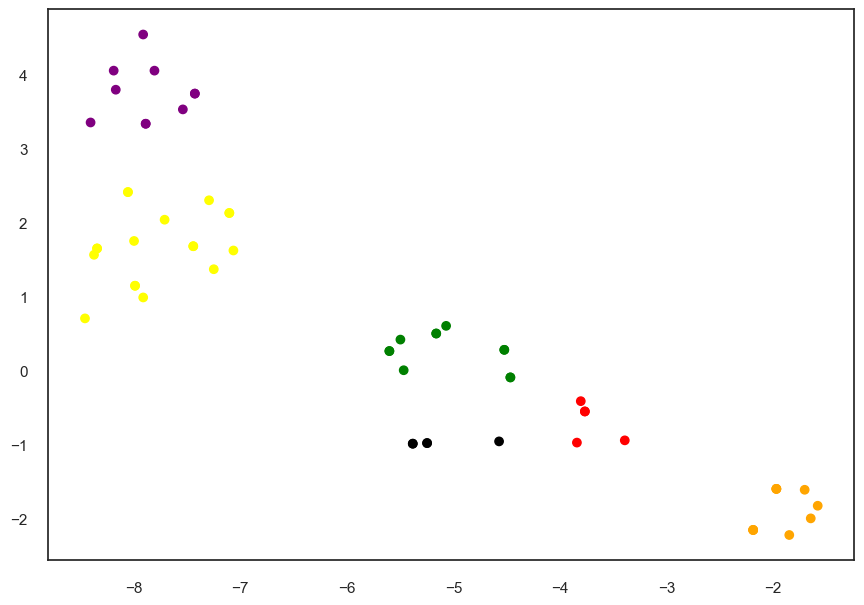

In [203]:
plt.scatter(transformed_hsi[:,0],transformed_hsi[:,1],c=gmm_label2,cmap=ListedColormap(colors))

Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


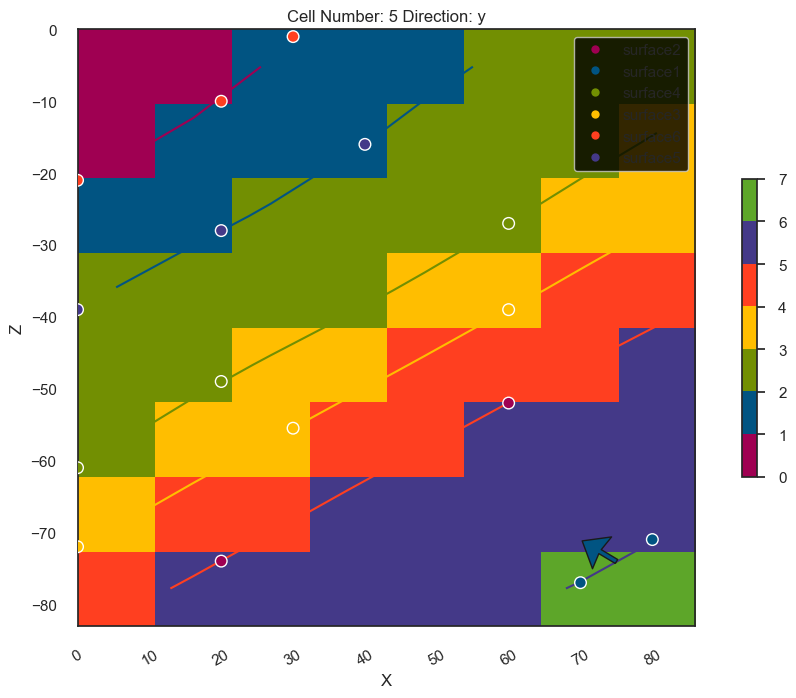

In [204]:
geo_model_test = gp.create_geomodel(
    project_name='Gempy_abc_Test',
    extent=[0, 86, -10, 10, -83, 0],
    resolution=[86,20,83],
    refinement=3,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )

gp.add_surface_points(
    geo_model=geo_model_test,
    x=[70.0, 80.0],
    y=[0.0, 0.0],
    z=[-77.0, -71.0],
    elements_names=['surface1', 'surface1']
)

gp.add_orientations(
    geo_model=geo_model_test,
    x=[75],
    y=[0.0],
    z=[-74],
    elements_names=['surface1'],
    pole_vector=[[-5/3, 0, 1]]
)
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)

element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([20.0, 60.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([-74, -52]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element2)

element3 = gp.data.StructuralElement(
    name='surface3',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 30.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-72, -55.5, -39]),
        names='surface3'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element3)

element4 = gp.data.StructuralElement(
    name='surface4',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-61, -49, -27]),
        names='surface4'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element4)

element5 = gp.data.StructuralElement(
    name='surface5',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0, 40]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-39, -28, -16]),
        names='surface5'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element5)

element6 = gp.data.StructuralElement(
    name='surface6',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0,30]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-21, -10, -1]),
        names='surface6'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element6)

geo_model_test.structural_frame.structural_groups[0].elements[0], geo_model_test.structural_frame.structural_groups[0].elements[1],\
geo_model_test.structural_frame.structural_groups[0].elements[2], geo_model_test.structural_frame.structural_groups[0].elements[3],\
geo_model_test.structural_frame.structural_groups[0].elements[4], geo_model_test.structural_frame.structural_groups[0].elements[5] = \
geo_model_test.structural_frame.structural_groups[0].elements[1], geo_model_test.structural_frame.structural_groups[0].elements[0],\
geo_model_test.structural_frame.structural_groups[0].elements[3], geo_model_test.structural_frame.structural_groups[0].elements[2],\
geo_model_test.structural_frame.structural_groups[0].elements[5], geo_model_test.structural_frame.structural_groups[0].elements[4]  

gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')


In [205]:
y_obs_label = 7 -y_obs[mask]
y_obs_label

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        6., 6., 6., 6., 6.], dtype=torch.float64)

In [206]:
x_loc = 20
y_loc = 0
z_loc = np.linspace(0,-82, 83)
print(z_loc)
xyz_coord = np.array([[x_loc, y_loc, z] for z in z_loc])[mask]
print(xyz_coord.shape)
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)

[  0.  -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10. -11. -12. -13.
 -14. -15. -16. -17. -18. -19. -20. -21. -22. -23. -24. -25. -26. -27.
 -28. -29. -30. -31. -32. -33. -34. -35. -36. -37. -38. -39. -40. -41.
 -42. -43. -44. -45. -46. -47. -48. -49. -50. -51. -52. -53. -54. -55.
 -56. -57. -58. -59. -60. -61. -62. -63. -64. -65. -66. -67. -68. -69.
 -70. -71. -72. -73. -74. -75. -76. -77. -78. -79. -80. -81. -82.]
(59, 3)
Active grids: ['custom']


In [207]:
geo_model_test.interpolation_options.mesh_extraction = False
sol = gp.compute_model(geo_model_test)

Setting Backend To: AvailableBackends.numpy


In [208]:
#gpv.plot_2d(geo_model_test, section_names=['section1'])

In [209]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
print(sp_coords_copy_test)
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

[[-2.75   0.     0.   ]
 [-0.75   0.     1.1  ]
 [-0.25   0.    -0.15 ]
 [ 0.25   0.     0.15 ]
 [-3.75   0.     0.65 ]
 [-2.75   0.     1.25 ]
 [-0.75   0.     2.35 ]
 [-3.75   0.     0.1  ]
 [-2.25   0.     0.925]
 [-0.75   0.     1.75 ]
 [-3.75   0.     2.65 ]
 [-2.75   0.     3.2  ]
 [-2.25   0.     3.65 ]
 [-3.75   0.     1.75 ]
 [-2.75   0.     2.3  ]
 [-1.75   0.     2.9  ]]


array([[ 20. ,   0. , -74. ],
       [ 60. ,   0. , -52. ],
       [ 70. ,   0. , -77. ],
       [ 80. ,   0. , -71. ],
       [  0. ,   0. , -61. ],
       [ 20. ,   0. , -49. ],
       [ 60. ,   0. , -27. ],
       [  0. ,   0. , -72. ],
       [ 30. ,   0. , -55.5],
       [ 60. ,   0. , -39. ],
       [  0. ,   0. , -21. ],
       [ 20. ,   0. , -10. ],
       [ 30. ,   0. ,  -1. ],
       [  0. ,   0. , -39. ],
       [ 20. ,   0. , -28. ],
       [ 40. ,   0. , -16. ]])

In [210]:
geo_model_test.surface_points

SurfacePointsTable(data=
[(20., 0., -74. , 20020670, 0.),(60., 0., -52. , 20020670, 0.),
 (70., 0., -77. ,  3671105, 0.),(80., 0., -71. ,  3671105, 0.),
 ( 0., 0., -61. , 58046635, 0.),(20., 0., -49. , 58046635, 0.),
 (60., 0., -27. , 58046635, 0.),( 0., 0., -72. , 80644639, 0.),
 (30., 0., -55.5, 80644639, 0.),(60., 0., -39. , 80644639, 0.),
 ( 0., 0., -21. , 11121998, 0.),(20., 0., -10. , 11121998, 0.),
 (30., 0.,  -1. , 11121998, 0.),( 0., 0., -39. ,  3718372, 0.),
 (20., 0., -28. ,  3718372, 0.),(40., 0., -16. ,  3718372, 0.)],
name_id_map={'surface2': 20020670, 'surface1': 3671105, 'surface4': 58046635, 'surface3': 80644639, 'surface6': 11121998, 'surface5': 3718372, 'basement': 8191475})

Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


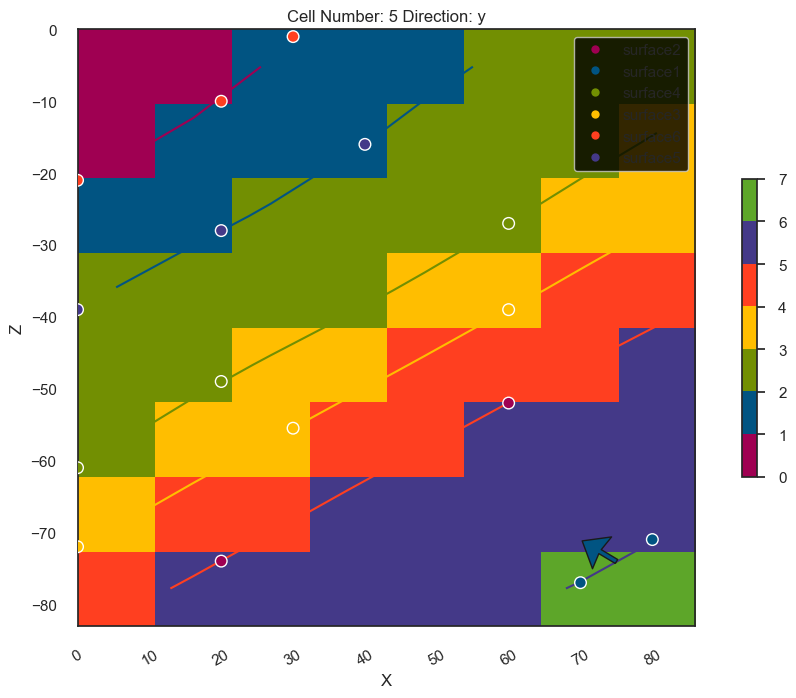

In [211]:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [212]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
print(sp_coords_copy_test)
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

[[-2.75   0.     0.   ]
 [-0.75   0.     1.1  ]
 [-0.25   0.    -0.15 ]
 [ 0.25   0.     0.15 ]
 [-3.75   0.     0.65 ]
 [-2.75   0.     1.25 ]
 [-0.75   0.     2.35 ]
 [-3.75   0.     0.1  ]
 [-2.25   0.     0.925]
 [-0.75   0.     1.75 ]
 [-3.75   0.     2.65 ]
 [-2.75   0.     3.2  ]
 [-2.25   0.     3.65 ]
 [-3.75   0.     1.75 ]
 [-2.75   0.     2.3  ]
 [-1.75   0.     2.9  ]]


array([[ 20. ,   0. , -74. ],
       [ 60. ,   0. , -52. ],
       [ 70. ,   0. , -77. ],
       [ 80. ,   0. , -71. ],
       [  0. ,   0. , -61. ],
       [ 20. ,   0. , -49. ],
       [ 60. ,   0. , -27. ],
       [  0. ,   0. , -72. ],
       [ 30. ,   0. , -55.5],
       [ 60. ,   0. , -39. ],
       [  0. ,   0. , -21. ],
       [ 20. ,   0. , -10. ],
       [ 30. ,   0. ,  -1. ],
       [  0. ,   0. , -39. ],
       [ 20. ,   0. , -28. ],
       [ 40. ,   0. , -16. ]])

In [213]:
# Change the backend to PyTorch for probabilistic modeling
BackendTensor.change_backend_gempy(engine_backend=gp.data.AvailableBackends.PYTORCH)

Setting Backend To: AvailableBackends.PYTORCH


In [214]:
# geo_model_test.interpolation_options.uni_degree = 0
# geo_model_test.interpolation_options.mesh_extraction = False
geo_model_test.interpolation_options.sigmoid_slope = 50

In [215]:
geo_model_test.solutions.octrees_output[0].last_output_center

InterpOutput(scalar_fields=ScalarFieldOutput(weights=array([-1.58450258e+00,  4.26719835e-17, -9.07995259e-01,  1.47537823e-02,
       -1.63896301e+00,  7.34936835e-02, -4.24866590e-03, -5.30118658e-02,
        5.72069162e-03, -1.48519490e-01,  1.22845313e-01,  4.64191770e-02,
       -4.14558661e-02, -7.47661279e-01, -2.00597546e-16,  1.31611094e+00]), grid=Grid(regular_grid=RegularGrid(extent=array([-3.749999,  0.550001, -0.499999,  0.500001, -0.449999,  3.700001]), regular_grid_shape=array([2, 2, 2])), custom_grid=GenericGrid(values=array([[-2.75,  0.  ,  3.7 ],
       [-2.75,  0.  ,  3.65],
       [-2.75,  0.  ,  3.6 ],
       [-2.75,  0.  ,  3.55],
       [-2.75,  0.  ,  3.5 ],
       [-2.75,  0.  ,  3.45],
       [-2.75,  0.  ,  3.4 ],
       [-2.75,  0.  ,  3.35],
       [-2.75,  0.  ,  3.3 ],
       [-2.75,  0.  ,  3.25],
       [-2.75,  0.  ,  2.8 ],
       [-2.75,  0.  ,  2.75],
       [-2.75,  0.  ,  2.7 ],
       [-2.75,  0.  ,  2.65],
       [-2.75,  0.  ,  2.6 ],
       [-

In [216]:
custom_grid_values1 = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
custom_grid_values1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 6., 6., 6., 6., 6.])

In [217]:
 
# # Compute the geological model
interpolation_input = geo_model_test.interpolation_input
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

# Compute and observe the thickness of the geological layer

custom_grid_values2 = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values

print(custom_grid_values2)

Condition number: 1549.941240198929.
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0032, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0008, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0015, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0014,
        5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0009,
        6.0000, 6.0000, 6.0000, 6.0000, 6.0000], dtype=torch.float64,
       grad_fn=<SliceBackward0>)


In [218]:
torch.tensor(custom_grid_values1) - custom_grid_values2

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -5.3291e-15,
        -1.0676e-12, -2.1966e-10, -4.8607e-08, -1.1807e-05, -3.2038e-03,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -4.8139e-13, -5.7525e-10, -6.9389e-07, -8.3637e-04,
         6.6285e-10,  6.0396e-13,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -5.3291e-15, -3.9524e-12,
        -2.9621e-09, -2.1426e-06, -1.4905e-03,  1.0658e-14,  0.0000e+00,
        -5.3291e-15, -4.2775e-12, -2.8276e-09, -1.9344e-06, -1.3722e-03,
         2.1831e-12,  2.6645e-15,  0.0000e+00,  0.0000e+00, -8.8818e-16,
        -6.4571e-13, -6.9269e-10, -7.6387e-07, -8.6315e-04,  4.7073e-13,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64, grad_fn=<SubBackward0>)

In [219]:
geo_model_test.surface_points

SurfacePointsTable(data=
[(20., 0., -74. , 20020670, 0.),(60., 0., -52. , 20020670, 0.),
 (70., 0., -77. ,  3671105, 0.),(80., 0., -71. ,  3671105, 0.),
 ( 0., 0., -61. , 58046635, 0.),(20., 0., -49. , 58046635, 0.),
 (60., 0., -27. , 58046635, 0.),( 0., 0., -72. , 80644639, 0.),
 (30., 0., -55.5, 80644639, 0.),(60., 0., -39. , 80644639, 0.),
 ( 0., 0., -21. , 11121998, 0.),(20., 0., -10. , 11121998, 0.),
 (30., 0.,  -1. , 11121998, 0.),( 0., 0., -39. ,  3718372, 0.),
 (20., 0., -28. ,  3718372, 0.),(40., 0., -16. ,  3718372, 0.)],
name_id_map={'surface2': 20020670, 'surface1': 3671105, 'surface4': 58046635, 'surface3': 80644639, 'surface6': 11121998, 'surface5': 3718372, 'basement': 8191475})

In [220]:
geo_model_test.orientations

OrientationsTable(data=
[(75., 0., -74., -1.67, 0., 1., 3671105, 0.01)],
name_id_map=None)

In [221]:
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 20. ,   0. , -74. ],
       [ 60. ,   0. , -52. ],
       [ 70. ,   0. , -77. ],
       [ 80. ,   0. , -71. ],
       [  0. ,   0. , -61. ],
       [ 20. ,   0. , -49. ],
       [ 60. ,   0. , -27. ],
       [  0. ,   0. , -72. ],
       [ 30. ,   0. , -55.5],
       [ 60. ,   0. , -39. ],
       [  0. ,   0. , -21. ],
       [ 20. ,   0. , -10. ],
       [ 30. ,   0. ,  -1. ],
       [  0. ,   0. , -39. ],
       [ 20. ,   0. , -28. ],
       [ 40. ,   0. , -16. ]])

Condition number: 1549.804761898595.
Condition number: 1549.804761898595.


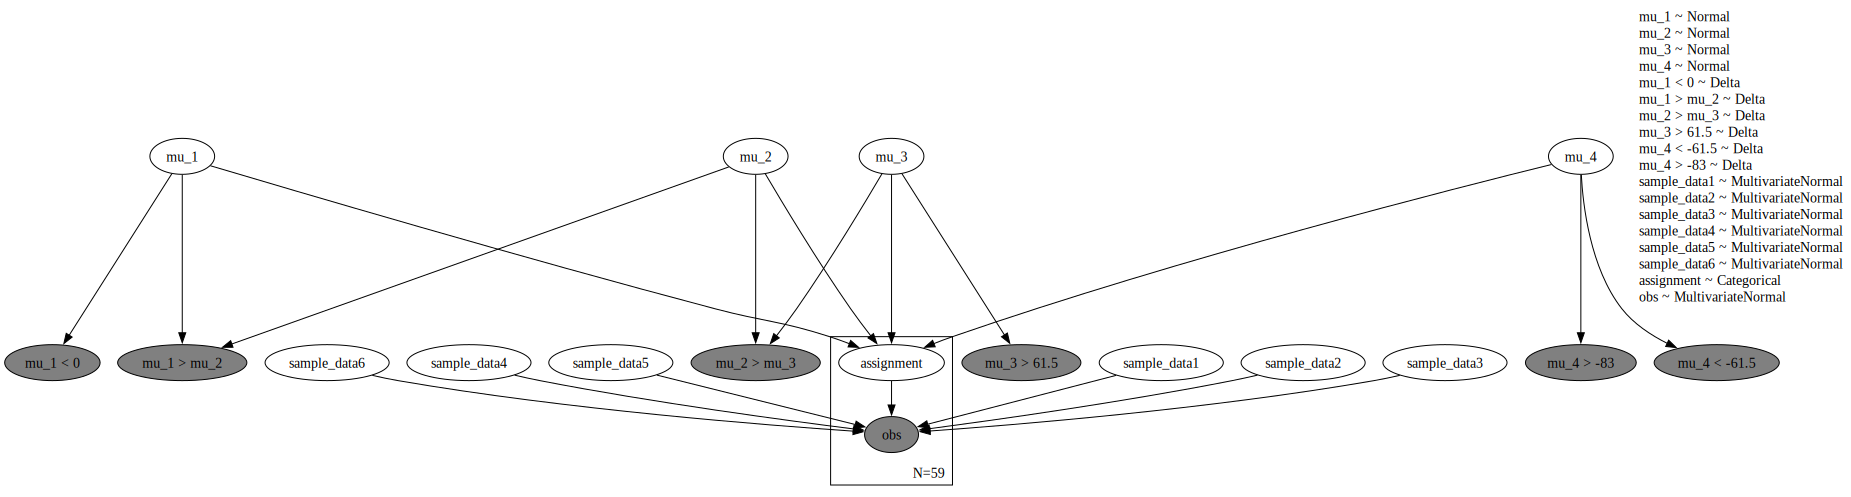

In [222]:

import torch.nn.functional as F
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.set_rng_seed(42)

@config_enumerate
def model_test(y_obs_label):
    """
    This Pyro model represents the probabilistic aspects of the geological model.
    It defines a prior distribution for the top layer's location and
    computes the thickness of the geological layer as an observed variable.
    """
    # Define prior for the top layer's location
    prior_mean_surface_1 = sp_coords_copy_test[11, 2]
    prior_mean_surface_2 = sp_coords_copy_test[14, 2]
    prior_mean_surface_3 = sp_coords_copy_test[5, 2]
    prior_mean_surface_4 = sp_coords_copy_test[0, 2]

    mu_surface_1 = pyro.sample('mu_1', dist.Normal(prior_mean_surface_1, torch.tensor(0.2, dtype=torch.float64)))
    mu_surface_2 = pyro.sample('mu_2', dist.Normal(prior_mean_surface_2, torch.tensor(0.2, dtype=torch.float64)))
    mu_surface_3 = pyro.sample('mu_3', dist.Normal(prior_mean_surface_3, torch.tensor(0.2, dtype=torch.float64)))
    mu_surface_4 = pyro.sample('mu_4', dist.Normal(prior_mean_surface_4, torch.tensor(0.2, dtype=torch.float64)))
    #print(mu_surface_1, mu_surface_2)
    # Ensure that mu_surface_1 is greater than mu_surface_2
    pyro.sample('mu_1 < 0', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 < 3.7))
    pyro.sample('mu_1 > mu_2', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 > mu_surface_2))
    pyro.sample('mu_2 > mu_3', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_2 > mu_surface_3))
    pyro.sample('mu_3 > 61.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_3 > 0.625))
    pyro.sample('mu_4 < -61.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_4 < 0.625))
    pyro.sample('mu_4 > -83', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_4 > - 0.2 ))
    # Update the model with the new top layer's location
    interpolation_input = geo_model_test.interpolation_input
    
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([11]), torch.tensor([2])),
        mu_surface_1
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([14]), torch.tensor([2])),
        mu_surface_2
    )
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        mu_surface_3
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([0]), torch.tensor([2])),
        mu_surface_4
    )
    
    
    #print("interpolation_input",interpolation_input.surface_points.sp_coords)
    
    # # Compute the geological model
    geo_model_test.solutions = gempy_engine.compute_model(
        interpolation_input=interpolation_input,
        options=geo_model_test.interpolation_options,
        data_descriptor=geo_model_test.input_data_descriptor,
        geophysics_input=geo_model_test.geophysics_input,
    )
    
    # Compute and observe the thickness of the geological layer
    
    custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    lambda_ = 10.0
    loc_mean = torch.tensor(mean_init,dtype=torch.float64)
    loc_cov =  torch.tensor(cov_init, dtype=torch.float64)
    class_label = F.softmax(-lambda_* (torch.tensor([1,2,3,4,5,6], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    sample =[]
    for i in range(loc_mean.shape[0]):
        sample_data = pyro.sample("sample_data"+str(i+1), dist.MultivariateNormal(loc=loc_mean[i],covariance_matrix=loc_cov[i]))
        sample.append(sample_data)
    sample_tesnor = torch.stack(sample, dim=0)
    
    with pyro.plate('N='+str(y_obs_label.shape[0]), y_obs_label.shape[0]):
        assignment = pyro.sample("assignment", dist.Categorical(class_label))
        #print("mean\n", mean[assignment])
        #obs = pyro.sample("obs", dist.Normal(custom_grid_values, 0.5 ), obs=y_obs_label.reshape(-1))
        #obs = pyro.sample("obs", dist.Normal(sample[assignment], 0.1 ), obs=y_obs_label.reshape(-1))
        #print(sample_tesnor[assignment].shape, loc_cov[assignment].shape, y_obs_label.shape)
        obs = pyro.sample("obs", dist.MultivariateNormal(loc=sample_tesnor[assignment],covariance_matrix=loc_cov[assignment]), obs=y_obs_label)
        #obs = pyro.sample("obs", dist.Normal(mean[assignment],  sigma[assignment]), obs=y_obs_label.reshape(-1))
    #return obs
dependencies = get_dependencies(model_test, model_args=(normalised_hsi,))
pyro.render_model(model_test, model_args=(normalised_hsi,),render_distributions=True)

In [223]:
print(normalised_hsi)
model_test(normalised_hsi)

tensor([[-0.0917, -0.1022,  0.6458,  ..., -2.0414, -2.0789, -2.1446],
        [-0.3896,  0.0792, -0.0924,  ..., -1.8319, -1.9459, -2.1446],
        [-0.3896,  0.0792, -0.0924,  ..., -1.8319, -1.9459, -2.1446],
        ...,
        [-0.0917, -1.4476, -1.4273,  ..., -0.5751, -0.4825, -0.4311],
        [-1.9709, -2.7326, -1.4587,  ..., -0.4180, -0.3495, -0.2507],
        [-1.9709, -2.7326, -1.4587,  ..., -0.4180, -0.3495, -0.2507]],
       dtype=torch.float64)
Condition number: 1549.8047618985954.


Condition number: 1527.6867238961302.
Condition number: 1537.0485943217252.
Condition number: 1527.4771691251901.
Condition number: 1552.144607096695.
Condition number: 1531.7482497489393.
Condition number: 1555.817162681595.
Condition number: 1565.3180175150708.
Condition number: 1548.9750969191825.
Condition number: 1558.468884643937.
Condition number: 1523.7339404199452.
Condition number: 1548.1453836146122.
Condition number: 1534.8628780790054.
Condition number: 1551.653656707808.
Condition number: 1539.1794681816993.
Condition number: 1542.5234609982824.
Condition number: 1545.1631239938567.
Condition number: 1552.8206276469987.
Condition number: 1544.4790185192232.
Condition number: 1522.0450689901622.
Condition number: 1535.7968980203566.
Condition number: 1527.8252333469181.
Condition number: 1560.420041775821.
Condition number: 1540.1334358769382.
Condition number: 1551.5752235834846.
Condition number: 1543.4278763759198.
Condition number: 1531.9768692680325.
Condition number:

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


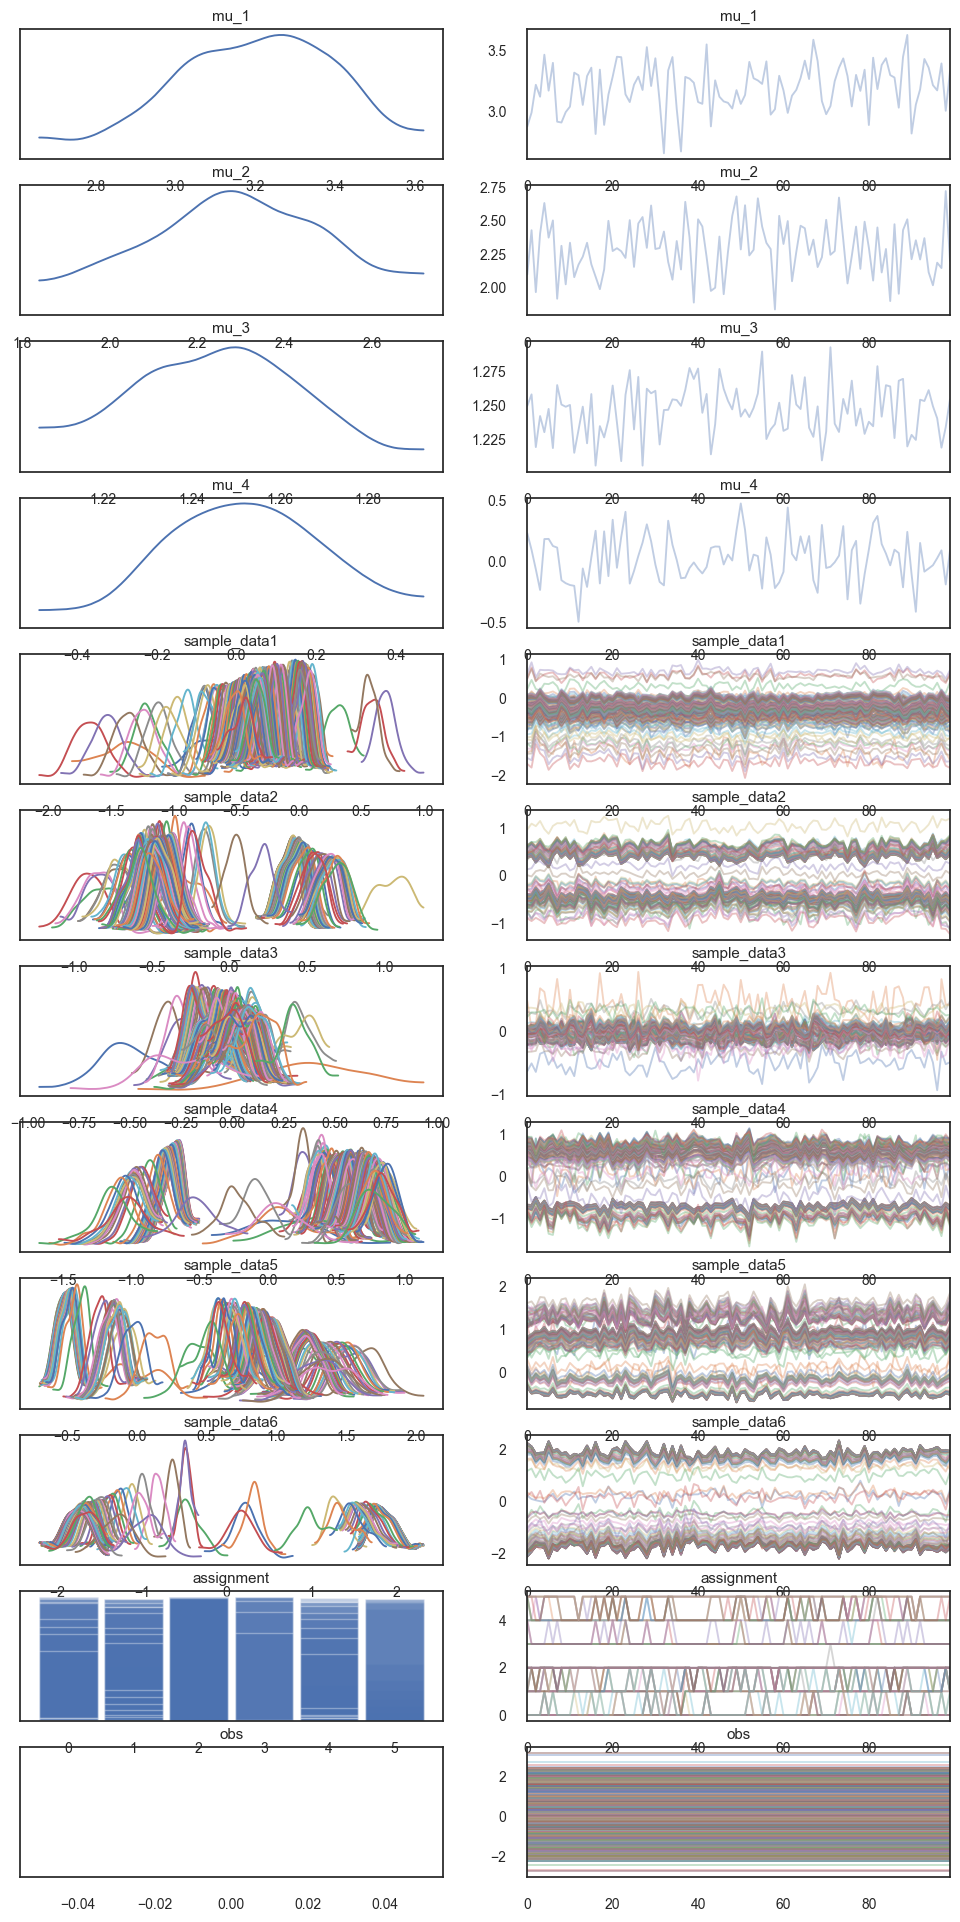

In [224]:
pyro.set_rng_seed(42)

prior = Predictive(model_test, num_samples=100)(normalised_hsi)

# Key to avoid
avoid_key = ['mu_1 < 0','mu_1 > mu_2','mu_2 > mu_3', 'mu_3 > 61.5','mu_4 < -61.5', 'mu_4 > -83']

# Create sub-dictionary without the avoid_key
prior = dict((key, value) for key, value in prior.items() if key not in avoid_key)

data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)
plt.show()

In [225]:
pyro.set_rng_seed(42)
pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(model_test, step_size=0.0085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10, init_strategy=init_to_mean)
#nuts_kernel = NUTS(model_test, step_size=0.00085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10)
#nuts_kernel = NUTS(model_test)
#initial_values = {'mu_1': torch.tensor(0.01, dtype=torch.float64),'mu_2': torch.tensor(0.01, dtype=torch.float64) }
initial_values = {'mu_1': torch.tensor(0.01, dtype=torch.float64),'mu_2': torch.tensor(0.01, dtype=torch.float64) }
#mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, disable_validation=False, initial_params=initial_values)
mcmc = MCMC(nuts_kernel, num_samples=50, warmup_steps=50, disable_validation=False)
mcmc.run(normalised_hsi)

Warmup:   0%|          | 0/100 [00:00, ?it/s]

Condition number: 1559.3705324134453.
Condition number: 1549.941240198929.
Condition number: 1549.941240198929.
Condition number: 1549.941240198929.
Condition number: 1549.941240198929.
Condition number: 1549.941240198929.
Condition number: 1549.7803085454384.
Condition number: 1549.941240198929.
Condition number: 1549.9928724131044.
Condition number: 1549.941240198929.
Condition number: 1550.0861465201056.
Condition number: 1549.941240198929.
Condition number: 1550.0076369843011.
Condition number: 1549.941240198929.
Condition number: 1550.0310590574652.
Condition number: 1549.941240198929.
Condition number: 1549.9633819395783.
Condition number: 1549.941240198929.
Condition number: 1549.9407628871943.
Condition number: 1549.941240198929.
Condition number: 1549.9374624961501.
Condition number: 1549.941240198929.
Condition number: 1549.9422938757173.
Condition number: 1549.941240198929.
Condition number: 1549.9419460907436.
Condition number: 1549.941240198929.
Condition number: 1549.9418

Warmup:   1%|          | 1/100 [00:02,  2.57s/it, step size=3.56e-05, acc. prob=0.434]

Condition number: 1549.9651405118382.
Condition number: 1549.9673275949158.
Condition number: 1549.969514924905.
Condition number: 1549.9717025005987.
Condition number: 1549.9738903207972.
Condition number: 1549.976078384293.
Condition number: 1549.978266689883.
Condition number: 1549.9607670912353.
Condition number: 1549.9585807561214.
Condition number: 1549.9563946727428.
Condition number: 1549.954208842301.
Condition number: 1549.9520232660116.


Warmup:   2%|▏         | 2/100 [00:03,  1.41s/it, step size=3.74e-06, acc. prob=0.242]

Condition number: 1549.949837945077.
Condition number: 1549.9476528807063.
Condition number: 1549.945468074113.
Condition number: 1549.9756080875645.
Condition number: 1549.975137793303.
Condition number: 1549.9746675015099.
Condition number: 1549.976548683479.
Condition number: 1549.977018985127.
Condition number: 1549.9774892892174.
Condition number: 1549.9779595957586.
Condition number: 1549.9741972121958.
Condition number: 1549.973726925363.
Condition number: 1549.9732566410155.
Condition number: 1549.972786359163.
Condition number: 1549.9723160798028.
Condition number: 1549.9718458029456.
Condition number: 1549.9713755285964.
Condition number: 1549.9709052567575.
Condition number: 1549.9784299047394.
Condition number: 1549.9789002161563.
Condition number: 1549.9793705300006.
Condition number: 1549.979840846274.
Condition number: 1549.9803111649621.
Condition number: 1549.9807814860685.
Condition number: 1549.9812518095814.
Condition number: 1549.9817221355004.
Condition number: 15

Warmup:   3%|▎         | 3/100 [00:08,  3.11s/it, step size=2.42e-06, acc. prob=0.458]

Condition number: 1549.9412834205523.
Condition number: 1549.9408133202212.
Condition number: 1549.9896496089766.
Condition number: 1549.9900515462984.
Condition number: 1549.9904534849788.
Condition number: 1549.990855425024.
Condition number: 1549.9912573664292.
Condition number: 1549.9916593091882.
Condition number: 1549.992061253308.
Condition number: 1549.9924631987824.
Condition number: 1549.992865145614.
Condition number: 1549.9932670937967.
Condition number: 1549.9936690433303.
Condition number: 1549.994070994212.
Condition number: 1549.9944729464476.
Condition number: 1549.9948749000284.
Condition number: 1549.9952768549542.
Condition number: 1549.9956788112224.
Condition number: 1549.9960807688376.
Condition number: 1549.996482727793.
Condition number: 1549.9968846880895.
Condition number: 1549.9972866497196.
Condition number: 1549.9976886126938.
Condition number: 1549.9980905770005.
Condition number: 1549.9984925426427.
Condition number: 1549.9988945096181.
Condition number:

Warmup:   4%|▍         | 4/100 [00:28,  9.98s/it, step size=2.50e-06, acc. prob=0.594]

Condition number: 1549.92217646582.
Condition number: 1549.9222083078012.
Condition number: 1549.9222401521233.
Condition number: 1549.922112788879.
Condition number: 1549.9220809539127.
Condition number: 1549.9220491212718.
Condition number: 1549.9220172909597.
Condition number: 1549.9222719987888.
Condition number: 1549.9223038478044.
Condition number: 1549.9223356991768.
Condition number: 1549.922367552906.
Condition number: 1549.9223994089893.
Condition number: 1549.9224312674414.
Condition number: 1549.922463128256.
Condition number: 1549.9224949914344.
Condition number: 1549.922526856991.
Condition number: 1549.9225587249207.
Condition number: 1549.9225905952294.
Condition number: 1549.922622467918.
Condition number: 1549.9226543429934.
Condition number: 1549.922686220457.
Condition number: 1549.9227181003137.
Condition number: 1549.9227499825588.
Condition number: 1549.9227818672064.
Condition number: 1549.9228137542534.
Condition number: 1549.9228456437045.
Condition number: 15

Warmup:   5%|▌         | 5/100 [00:33,  8.21s/it, step size=2.89e-06, acc. prob=0.675]

Condition number: 1549.9199848455676.
Condition number: 1549.9219000116661.
Condition number: 1549.9221327099635.
Condition number: 1549.9223654051082.
Condition number: 1549.9225980971069.
Condition number: 1549.9228307859478.
Condition number: 1549.9230634716362.
Condition number: 1549.9232961541709.
Condition number: 1549.9235288335444.
Condition number: 1549.9237615097657.
Condition number: 1549.9239941828264.
Condition number: 1549.9242268527264.
Condition number: 1549.9244595194652.
Condition number: 1549.9246921830422.
Condition number: 1549.9249248434587.
Condition number: 1549.9251575007079.
Condition number: 1549.9253901547934.
Condition number: 1549.9256228057134.
Condition number: 1549.9258554534651.
Condition number: 1549.9260880980464.
Condition number: 1549.9263207394597.
Condition number: 1549.9265533777032.
Condition number: 1549.9267860127695.
Condition number: 1549.927018644666.
Condition number: 1549.9272512733883.
Condition number: 1549.9274838989327.
Condition num

Warmup:   6%|▌         | 6/100 [01:14, 19.30s/it, step size=3.58e-06, acc. prob=0.729]

Condition number: 1550.0100155694072.
Condition number: 1550.0099428599824.
Condition number: 1550.0098701528314.
Condition number: 1550.009797447949.
Condition number: 1550.009724745335.
Condition number: 1550.009652044992.
Condition number: 1550.0095793469204.
Condition number: 1550.0101609950705.
Condition number: 1550.0102337113094.
Condition number: 1550.0103064298241.
Condition number: 1550.0103791506135.
Condition number: 1550.0104518736778.
Condition number: 1550.0105245990194.
Condition number: 1550.0105973266357.
Condition number: 1550.0106700565302.
Condition number: 1550.0107427887042.
Condition number: 1550.0108155231549.
Condition number: 1550.0108882598877.
Condition number: 1550.010960998902.
Condition number: 1550.0110337401927.
Condition number: 1550.0111064837724.
Condition number: 1550.011179229629.
Condition number: 1550.011251977767.
Condition number: 1550.0113247281947.
Condition number: 1550.0113974809053.
Condition number: 1550.0114702359008.
Condition number: 

Warmup:   7%|▋         | 7/100 [01:56, 26.63s/it, step size=4.46e-06, acc. prob=0.766]

Condition number: 1550.0659099851198.
Condition number: 1550.0659846293738.
Condition number: 1550.0660592764455.
Condition number: 1550.0592291614878.
Condition number: 1550.0599217423398.
Condition number: 1550.060268043428.
Condition number: 1550.0588828817556.
Condition number: 1550.0585366091727.
Condition number: 1550.0581903437565.
Condition number: 1550.0578440855134.
Condition number: 1550.0574978344678.
Condition number: 1550.0571515906292.
Condition number: 1550.0568053540192.
Condition number: 1550.0564591246434.
Condition number: 1550.0561129025275.
Condition number: 1550.0557666876784.
Condition number: 1550.0554204801153.
Condition number: 1550.055074279852.
Condition number: 1550.0606143516054.
Condition number: 1550.060960666855.
Condition number: 1550.061306989165.
Condition number: 1550.0616533185148.
Condition number: 1550.0619996548958.
Condition number: 1550.0623459982892.
Condition number: 1550.0626923486814.
Condition number: 1550.0630387060532.
Condition number

Warmup:   8%|▊         | 8/100 [01:58, 18.96s/it, step size=5.77e-06, acc. prob=0.794]

Condition number: 1550.0762053122694.
Condition number: 1550.0765519302759.
Condition number: 1550.076898554667.
Condition number: 1550.0695892710346.
Condition number: 1550.0689593578059.
Condition number: 1550.0686443972759.
Condition number: 1550.0683294341275.
Condition number: 1550.0680144683572.
Condition number: 1550.0676994999708.
Condition number: 1550.0673845289548.
Condition number: 1550.0699042237316.
Condition number: 1550.070219173828.
Condition number: 1550.0705341213197.
Condition number: 1550.0708490662132.
Condition number: 1550.0711640085099.
Condition number: 1550.0714789482167.
Condition number: 1550.071793885332.
Condition number: 1550.0721088198602.
Condition number: 1550.072423751804.
Condition number: 1550.072738681169.
Condition number: 1550.0730536079523.
Condition number: 1550.0733685321627.
Condition number: 1550.0736834538016.
Condition number: 1550.0739983728743.
Condition number: 1550.074313289377.
Condition number: 1550.0746282033176.
Condition number: 

Warmup:   9%|▉         | 9/100 [02:40, 25.97s/it, step size=7.74e-06, acc. prob=0.817]

Condition number: 1550.3777751019693.
Condition number: 1550.3780889358798.
Condition number: 1550.3784027700997.
Condition number: 1550.3787166046422.
Condition number: 1550.3627713496594.
Condition number: 1550.3631451440976.
Condition number: 1550.3635189483532.
Condition number: 1550.3638927624283.
Condition number: 1550.36426658632.
Condition number: 1550.3646404200201.
Condition number: 1550.3650142635327.
Condition number: 1550.3653881168473.
Condition number: 1550.3657619799617.
Condition number: 1550.3661358528786.
Condition number: 1550.3665097355781.
Condition number: 1550.3668836280754.
Condition number: 1550.367257530357.
Condition number: 1550.3676314424238.
Condition number: 1550.368005364269.
Condition number: 1550.3683792958896.
Condition number: 1550.3687532372815.
Condition number: 1550.3691271884443.
Condition number: 1550.36950114937.
Condition number: 1550.369875120056.
Condition number: 1550.3702491005.
Condition number: 1550.3706230907003.
Condition number: 1550

Warmup:  10%|█         | 10/100 [02:49, 20.81s/it, step size=1.04e-05, acc. prob=0.834]

Condition number: 1550.3250693331274.
Condition number: 1550.324696559129.
Condition number: 1550.3243237953152.
Condition number: 1550.3239510416884.
Condition number: 1550.3235782982506.
Condition number: 1550.4032019075698.
Condition number: 1550.401707299469.
Condition number: 1550.4002127349288.
Condition number: 1550.4061912533896.
Condition number: 1550.4076859905713.
Condition number: 1550.4091807702493.
Condition number: 1550.410675592158.
Condition number: 1550.3987182142134.
Condition number: 1550.3972237375917.
Condition number: 1550.3957293053338.
Condition number: 1550.3942349177019.
Condition number: 1550.3927405749696.
Condition number: 1550.391246277401.
Condition number: 1550.3897520252601.
Condition number: 1550.3882578188252.
Condition number: 1550.4121704560282.
Condition number: 1550.4136653615953.
Condition number: 1550.415160308596.
Condition number: 1550.4166552967652.
Condition number: 1550.418150325836.
Condition number: 1550.4196453955456.
Condition number: 

Warmup:  11%|█         | 11/100 [03:02, 18.29s/it, step size=7.77e-06, acc. prob=0.832]

Condition number: 1550.2614461457279.
Condition number: 1550.2599568918997.
Condition number: 1550.2584677077516.
Condition number: 1550.2569785935655.
Condition number: 1550.2554895496185.
Condition number: 1550.6431356882397.
Condition number: 1550.645048780658.
Condition number: 1550.6469618688009.
Condition number: 1550.6488749526018.
Condition number: 1550.6507880319998.
Condition number: 1550.6527011069272.
Condition number: 1550.654614177321.
Condition number: 1550.656527243119.
Condition number: 1550.6584403042525.
Condition number: 1550.66035336066.
Condition number: 1550.662266412282.
Condition number: 1550.664179459048.
Condition number: 1550.6660925008978.
Condition number: 1550.6680055377653.
Condition number: 1550.6699185695916.
Condition number: 1550.671831596306.
Condition number: 1550.6737446178508.
Condition number: 1550.675657634158.
Condition number: 1550.677570645169.
Condition number: 1550.6794836508195.
Condition number: 1550.681396651043.
Condition number: 1550.

Warmup:  12%|█▏        | 12/100 [03:17, 17.32s/it, step size=1.01e-05, acc. prob=0.844]

Condition number: 1550.1744669897432.
Condition number: 1550.1725549310866.
Condition number: 1550.1706428855914.
Condition number: 1550.4825411803506.
Condition number: 1550.4807417765303.
Condition number: 1550.478942370273.
Condition number: 1550.4861399803106.
Condition number: 1550.4879393762699.
Condition number: 1550.4897387694225.
Condition number: 1550.4915381596752.
Condition number: 1550.4933375469395.
Condition number: 1550.4951369311184.
Condition number: 1550.4969363121245.
Condition number: 1550.4987356898594.
Condition number: 1550.500535064235.
Condition number: 1550.502334435163.
Condition number: 1550.5041338025446.
Condition number: 1550.5059331662906.
Condition number: 1550.4771429616726.
Condition number: 1550.4753435508248.
Condition number: 1550.4735441378182.
Condition number: 1550.4717447227454.
Condition number: 1550.4699453057053.
Condition number: 1550.4681458867824.
Condition number: 1550.466346466078.
Condition number: 1550.4645470436799.
Condition number

Warmup:  13%|█▎        | 13/100 [03:18, 12.44s/it, step size=1.31e-05, acc. prob=0.855]

Condition number: 1550.457626328338.
Condition number: 1550.4570723328752.
Condition number: 1550.4567953099547.
Condition number: 1550.4579033007687.
Condition number: 1550.4581802562602.
Condition number: 1550.4584571947557.
Condition number: 1550.4587341161969.
Condition number: 1550.456518270317.
Condition number: 1550.4562412140187.
Condition number: 1550.4559641411142.
Condition number: 1550.4556870516576.
Condition number: 1550.4554099457084.
Condition number: 1550.455132823319.
Condition number: 1550.4548556845511.
Condition number: 1550.4545785294517.
Condition number: 1550.459011020531.
Condition number: 1550.459287907699.
Condition number: 1550.4595647776493.
Condition number: 1550.4598416303243.
Condition number: 1550.4601184656653.
Condition number: 1550.460395283621.
Condition number: 1550.4606720841373.
Condition number: 1550.460948867151.
Condition number: 1550.4612256326136.
Condition number: 1550.4615023804647.
Condition number: 1550.46177911065.
Condition number: 155

Warmup:  14%|█▍        | 14/100 [03:34, 13.59s/it, step size=1.65e-05, acc. prob=0.863]

Condition number: 1550.5145177023035.
Condition number: 1550.5147899897052.
Condition number: 1550.5150622487874.
Condition number: 1550.5153344794994.
Condition number: 1550.515606681783.
Condition number: 1550.4267808764587.
Condition number: 1550.4253791607853.
Condition number: 1550.4239774559537.
Condition number: 1550.4295843392374.
Condition number: 1550.4309860857936.
Condition number: 1550.4323878420967.
Condition number: 1550.433789607868.
Condition number: 1550.4351913828343.
Condition number: 1550.43659316672.
Condition number: 1550.4379949592542.
Condition number: 1550.4393967601636.
Condition number: 1550.440798569169.
Condition number: 1550.4422003860009.
Condition number: 1550.4436022103819.
Condition number: 1550.4450040420409.
Condition number: 1550.4464058807068.
Condition number: 1550.4478077261024.
Condition number: 1550.4492095779544.
Condition number: 1550.4506114359915.
Condition number: 1550.4520132999392.
Condition number: 1550.4534151695304.
Condition number:

Warmup:  15%|█▌        | 15/100 [04:15, 21.90s/it, step size=1.40e-05, acc. prob=0.862]

Condition number: 1549.3752898079235.
Condition number: 1549.3739825034604.
Condition number: 1549.372675434994.
Condition number: 1549.5314122336138.
Condition number: 1549.5316957091818.
Condition number: 1549.5319793095289.
Condition number: 1549.5322630346925.
Condition number: 1549.5325468847147.
Condition number: 1549.532830859633.
Condition number: 1549.533114959483.
Condition number: 1549.5333991843038.
Condition number: 1549.533683534133.
Condition number: 1549.5339680090092.
Condition number: 1549.5342526089698.
Condition number: 1549.534537334055.
Condition number: 1549.534822184299.
Condition number: 1549.5351071597427.
Condition number: 1549.5353922604206.
Condition number: 1549.5308456566663.
Condition number: 1549.530562555209.
Condition number: 1549.5302795783807.
Condition number: 1549.5299967261324.
Condition number: 1549.529713998441.
Condition number: 1549.5294313952559.
Condition number: 1549.5291489165452.
Condition number: 1549.5288665622656.
Condition number: 15

Warmup:  16%|█▌        | 16/100 [04:57, 27.78s/it, step size=1.90e-05, acc. prob=0.870]

Condition number: 1549.8442175575547.
Condition number: 1549.7949286161827.
Condition number: 1549.7957286510461.
Condition number: 1549.796129091971.
Condition number: 1549.7945290225941.
Condition number: 1549.7941297117993.
Condition number: 1549.793730683979.
Condition number: 1549.7933319392969.
Condition number: 1549.792933477934.
Condition number: 1549.7925353000603.
Condition number: 1549.7921374058535.
Condition number: 1549.7917397954852.


Warmup:  17%|█▋        | 17/100 [04:57, 19.61s/it, step size=1.19e-05, acc. prob=0.863]

Condition number: 1549.7913424691226.
Condition number: 1549.790945426944.
Condition number: 1549.790548669126.
Condition number: 1549.7901521958313.
Condition number: 1549.7927506197827.
Condition number: 1549.788346859846.
Condition number: 1549.7861451923197.
Condition number: 1549.7839436669308.
Condition number: 1549.781742284054.
Condition number: 1549.7795410440688.
Condition number: 1549.7773399473558.
Condition number: 1549.7949527114404.
Condition number: 1549.79715494372.
Condition number: 1549.7993573162453.
Condition number: 1549.8015598286368.
Condition number: 1549.8037624805177.
Condition number: 1549.805965271511.
Condition number: 1549.808168201242.
Condition number: 1549.810371269329.
Condition number: 1549.8125744754034.
Condition number: 1549.8147778190823.
Condition number: 1549.8169812999927.
Condition number: 1549.8191849177533.
Condition number: 1549.8213886719977.
Condition number: 1549.8235925623478.
Condition number: 1549.8257965884177.
Condition number: 154

Warmup:  18%|█▊        | 18/100 [05:41, 26.75s/it, step size=1.45e-05, acc. prob=0.868]

Condition number: 1548.7023480388775.
Condition number: 1548.703815187563.
Condition number: 1548.7052828228545.
Condition number: 1548.7067509441122.
Condition number: 1548.7082195506948.
Condition number: 1548.7096886419704.
Condition number: 1548.711158217299.
Condition number: 1548.7126282760446.
Condition number: 1548.7140988175647.
Condition number: 1548.7155698412264.
Condition number: 1548.7170413463816.
Condition number: 1548.7185133323985.
Condition number: 1548.7199857986373.
Condition number: 1548.7214587444596.
Condition number: 1548.7229321692248.
Condition number: 1548.7244060722905.
Condition number: 1548.7258804530188.
Condition number: 1548.7273553107677.
Condition number: 1548.7288306449009.
Condition number: 1548.7303064547734.
Condition number: 1548.7317827397449.
Condition number: 1548.733259499176.
Condition number: 1548.7347367324257.
Condition number: 1548.7362144388517.
Condition number: 1548.7376926178072.
Condition number: 1548.7391712686613.
Condition numbe

Warmup:  19%|█▉        | 19/100 [06:23, 31.35s/it, step size=1.63e-05, acc. prob=0.872]

Condition number: 1547.764326480968.
Condition number: 1547.7633986110557.
Condition number: 1547.7624716235925.
Condition number: 1548.2912868616008.
Condition number: 1548.2917079696274.
Condition number: 1548.292129912979.
Condition number: 1548.2925526918027.
Condition number: 1548.2929763062589.
Condition number: 1548.2934007565025.
Condition number: 1548.2938260426827.
Condition number: 1548.2904471508912.
Condition number: 1548.2900285478954.
Condition number: 1548.2896107795962.
Condition number: 1548.2891938458354.
Condition number: 1548.2887777464573.
Condition number: 1548.2883624812985.
Condition number: 1548.2879480502068.
Condition number: 1548.2875344530128.
Condition number: 1548.2942521649575.
Condition number: 1548.2946791234776.
Condition number: 1548.2951069183914.
Condition number: 1548.2955355498564.
Condition number: 1548.2959650180196.
Condition number: 1548.2963953230349.
Condition number: 1548.296826465047.
Condition number: 1548.2972584442105.
Condition numbe

Warmup:  20%|██        | 20/100 [07:04, 34.28s/it, step size=2.10e-05, acc. prob=0.877]

Condition number: 1548.1967759424972.
Condition number: 1548.1969192428385.
Condition number: 1548.1898929849654.
Condition number: 1548.1903139327878.
Condition number: 1548.1905262052394.
Condition number: 1548.1896843105708.
Condition number: 1548.189476836507.
Condition number: 1548.189270563259.
Condition number: 1548.189065491309.
Condition number: 1548.1888616211493.
Condition number: 1548.1886589532567.
Condition number: 1548.1884574881149.
Condition number: 1548.188257226205.
Condition number: 1548.1880581680098.
Condition number: 1548.1878603139971.
Condition number: 1548.1876636646566.
Condition number: 1548.1874682204527.
Condition number: 1548.187273981869.
Condition number: 1548.1870809493744.
Condition number: 1548.186889123443.
Condition number: 1548.186698504545.
Condition number: 1548.186509093148.
Condition number: 1548.1863208897246.
Condition number: 1548.1861338947367.
Condition number: 1548.1859481086542.
Condition number: 1548.1857635319393.
Condition number: 15

Warmup:  21%|██        | 21/100 [07:07, 24.74s/it, step size=8.66e-06, acc. prob=0.864]

Condition number: 1548.1852003695128.
Condition number: 1548.1853636198373.
Condition number: 1548.185527078956.
Condition number: 1548.184874495465.
Condition number: 1548.1847118718522.
Condition number: 1548.18454945725.
Condition number: 1548.1843872517077.
Condition number: 1548.1842252552863.
Condition number: 1548.1840634680318.
Condition number: 1548.183901890002.
Condition number: 1548.1837405212514.
Condition number: 1548.183579361828.
Condition number: 1548.1834184117945.
Condition number: 1548.1832576711906.
Condition number: 1548.1830971400782.
Condition number: 1548.182936818511.
Condition number: 1548.1827767065379.
Condition number: 1548.1826168042146.
Condition number: 1548.1824571115933.
Condition number: 1548.1822976287235.
Condition number: 1548.182138355669.
Condition number: 1548.18197929247.
Condition number: 1548.1818204391855.
Condition number: 1548.1816617958693.
Condition number: 1548.1815033625696.
Condition number: 1548.181345139344.
Condition number: 1548.

Warmup:  22%|██▏       | 22/100 [07:13, 19.22s/it, step size=1.07e-05, acc. prob=0.868]

Condition number: 1548.208154077533.
Condition number: 1548.1943111026092.
Condition number: 1548.1955245557965.
Condition number: 1548.1967383268673.
Condition number: 1548.1979524156495.
Condition number: 1548.1991668219805.
Condition number: 1548.2003815456956.
Condition number: 1548.2015965866271.
Condition number: 1548.202811944613.
Condition number: 1548.2040276194864.
Condition number: 1548.205243611086.
Condition number: 1548.2064599192402.
Condition number: 1548.2076765437882.
Condition number: 1548.208893484562.
Condition number: 1548.2101107413932.
Condition number: 1548.2113283141234.
Condition number: 1548.2125462025817.
Condition number: 1548.2137644066033.
Condition number: 1548.2149829260245.
Condition number: 1548.2162017606738.
Condition number: 1548.2174209103919.
Condition number: 1548.21864037501.
Condition number: 1548.2198601543575.
Condition number: 1548.221080248272.
Condition number: 1548.222300656588.
Condition number: 1548.2235213791391.
Condition number: 15

Warmup:  23%|██▎       | 23/100 [07:54, 25.72s/it, step size=1.39e-05, acc. prob=0.873]

Condition number: 1549.1128008015858.
Condition number: 1549.1141927523258.
Condition number: 1548.6983409888.
Condition number: 1548.697519635165.
Condition number: 1548.6971095659317.
Condition number: 1548.6987522728234.
Condition number: 1548.6991639614102.
Condition number: 1548.6995760543678.
Condition number: 1548.699988551508.
Condition number: 1548.6966999020015.
Condition number: 1548.696290643562.
Condition number: 1548.6958817907948.
Condition number: 1548.6954733438897.
Condition number: 1548.6950653030297.
Condition number: 1548.6946576683977.
Condition number: 1548.6942504401818.
Condition number: 1548.6938436185685.
Condition number: 1548.700401452646.
Condition number: 1548.700814757599.
Condition number: 1548.701228466176.
Condition number: 1548.701642578184.
Condition number: 1548.702057093443.
Condition number: 1548.7024720117631.
Condition number: 1548.7028873329546.
Condition number: 1548.7033030568289.
Condition number: 1548.7037191832003.
Condition number: 1548.

Warmup:  24%|██▍       | 24/100 [08:35, 30.32s/it, step size=1.49e-05, acc. prob=0.875]

Condition number: 1548.542746314193.
Condition number: 1548.5425677124817.
Condition number: 1548.6918206049677.
Condition number: 1548.689387306824.
Condition number: 1548.6881714100696.
Condition number: 1548.6869560157709.
Condition number: 1548.6857411246122.
Condition number: 1548.6845267372817.
Condition number: 1548.6833128544615.
Condition number: 1548.6820994768334.
Condition number: 1548.6808866050826.
Condition number: 1548.679674239896.
Condition number: 1548.6784623819512.
Condition number: 1548.6772510319352.
Condition number: 1548.6760401905278.
Condition number: 1548.6748298584168.
Condition number: 1548.6736200362782.
Condition number: 1548.6724107247994.
Condition number: 1548.6712019246577.
Condition number: 1548.6699936365405.
Condition number: 1548.6687858611222.
Condition number: 1548.6675785990938.
Condition number: 1548.6663718511297.
Condition number: 1548.6651656179108.
Condition number: 1548.6639599001237.
Condition number: 1548.6627546984444.
Condition numbe

Warmup:  25%|██▌       | 25/100 [09:15, 33.43s/it, step size=1.79e-05, acc. prob=0.879]

Condition number: 1547.977076221326.
Condition number: 1547.9763891813193.
Condition number: 1547.9757030573792.
Condition number: 1547.9750178499246.
Condition number: 1547.9743335593707.
Condition number: 1548.1875673739737.
Condition number: 1548.1869997442518.
Condition number: 1548.1867175560858.
Condition number: 1548.186436452537.
Condition number: 1548.1861564337134.
Condition number: 1548.1858774997413.
Condition number: 1548.185599650727.
Condition number: 1548.1878528152974.
Condition number: 1548.1881393407693.
Condition number: 1548.1884269502748.
Condition number: 1548.1887156437006.
Condition number: 1548.189005420914.
Condition number: 1548.1892962818026.
Condition number: 1548.189588226244.
Condition number: 1548.1898812541194.
Condition number: 1548.1853228867794.
Condition number: 1548.1850472080062.
Condition number: 1548.1847726145302.
Condition number: 1548.1844991064504.
Condition number: 1548.184226683879.
Condition number: 1548.1839553469265.
Condition number: 

Warmup:  26%|██▌       | 26/100 [09:18, 24.19s/it, step size=1.60e-05, acc. prob=0.878]

Condition number: 1548.1817322358352.
Condition number: 1548.1819031782059.
Condition number: 1548.182075011684.
Condition number: 1548.182247736445.
Condition number: 1548.1824213526584.
Condition number: 1548.1825958604986.
Condition number: 1548.1827712601341.
Condition number: 1548.1813930237263.
Condition number: 1548.1812247536434.
Condition number: 1548.1810573739692.
Condition number: 1548.180890884534.
Condition number: 1548.1807252851609.
Condition number: 1548.1805605756695.
Condition number: 1548.1803967558874.
Condition number: 1548.1802338256348.
Condition number: 1548.1829475517402.
Condition number: 1548.1831247354849.
Condition number: 1548.1833028115389.
Condition number: 1548.183481780065.
Condition number: 1548.1836616412404.
Condition number: 1548.183842395226.
Condition number: 1548.1840240421984.
Condition number: 1548.184206582318.
Condition number: 1548.1843900157496.
Condition number: 1548.1845743426654.
Condition number: 1548.1847595632275.
Condition number: 

Warmup:  27%|██▋       | 27/100 [09:59, 29.19s/it, step size=1.40e-05, acc. prob=0.876]

Condition number: 1548.2953706414385.
Condition number: 1548.295799628822.
Condition number: 1548.2962292303223.
Condition number: 1548.2966594454147.
Condition number: 1548.297090273583.
Condition number: 1548.2468037300118.
Condition number: 1548.2439288581932.
Condition number: 1548.2424921849104.
Condition number: 1548.2482419277433.
Condition number: 1548.249680632813.
Condition number: 1548.2511198448258.
Condition number: 1548.252559563368.
Condition number: 1548.2539997880365.
Condition number: 1548.2554405184235.
Condition number: 1548.2568817541296.
Condition number: 1548.2583234947492.
Condition number: 1548.259765739865.
Condition number: 1548.261208489086.
Condition number: 1548.2626517419928.
Condition number: 1548.2640954981903.
Condition number: 1548.241056020589.
Condition number: 1548.2396203656306.
Condition number: 1548.2381852204326.
Condition number: 1548.2367505854088.
Condition number: 1548.235316460953.
Condition number: 1548.233882847471.
Condition number: 154

Warmup:  28%|██▊       | 28/100 [10:43, 33.72s/it, step size=1.53e-05, acc. prob=0.878]

Condition number: 1549.2184949495543.
Condition number: 1549.2182328686413.
Condition number: 1549.2179710557448.
Condition number: 1549.2177095108045.
Condition number: 1549.2174482337675.
Condition number: 1549.2171872245715.
Condition number: 1549.216926483157.
Condition number: 1549.2190199156485.
Condition number: 1549.2192828009477.
Condition number: 1549.2195459544864.
Condition number: 1549.2198093763263.
Condition number: 1549.220073066521.
Condition number: 1549.2203370251307.
Condition number: 1549.2206012522051.
Condition number: 1549.2208657478018.
Condition number: 1549.221130511983.
Condition number: 1549.221395544798.
Condition number: 1549.221660846307.
Condition number: 1549.2219264165624.
Condition number: 1549.2221922556257.
Condition number: 1549.2224583635434.
Condition number: 1549.222724740377.
Condition number: 1549.2229913861822.
Condition number: 1549.2232583010095.
Condition number: 1549.2235254849168.
Condition number: 1549.2237929379578.
Condition number: 

Warmup:  29%|██▉       | 29/100 [11:28, 36.98s/it, step size=1.07e-05, acc. prob=0.874]

Condition number: 1549.6281390250265.
Condition number: 1549.4728464906914.
Condition number: 1549.4732192930246.
Condition number: 1549.4735922243044.
Condition number: 1549.4721012731259.
Condition number: 1549.4717288580214.
Condition number: 1549.471356572115.
Condition number: 1549.4709844154731.
Condition number: 1549.4739652844723.
Condition number: 1549.4743384734668.
Condition number: 1549.4747117912202.
Condition number: 1549.4750852376678.
Condition number: 1549.4754588127569.
Condition number: 1549.4758325164137.
Condition number: 1549.4762063485782.
Condition number: 1549.4765803091907.
Condition number: 1549.476954398183.
Condition number: 1549.4773286154953.
Condition number: 1549.4777029610632.
Condition number: 1549.4780774348253.
Condition number: 1549.4784520367157.
Condition number: 1549.4788267666727.
Condition number: 1549.4792016246342.
Condition number: 1549.4795766105358.
Condition number: 1549.479951724312.
Condition number: 1549.4803269659058.
Condition numbe

Warmup:  30%|███       | 30/100 [12:12, 39.17s/it, step size=1.41e-05, acc. prob=0.878]

Condition number: 1549.2627124279825.
Condition number: 1549.262434292109.
Condition number: 1549.2621563194587.
Condition number: 1549.261878510074.
Condition number: 1549.316423010033.
Condition number: 1549.3143627811708.
Condition number: 1549.313333149826.
Condition number: 1549.31230384147.
Condition number: 1549.3112748567953.
Condition number: 1549.3102461964909.
Condition number: 1549.3092178612594.
Condition number: 1549.3174536061667.
Condition number: 1549.3184845225132.
Condition number: 1549.3195157583727.
Condition number: 1549.3205473130515.
Condition number: 1549.321579185859.
Condition number: 1549.3226113761036.
Condition number: 1549.3236438830877.
Condition number: 1549.324676706115.
Condition number: 1549.3257098444965.
Condition number: 1549.3267432975365.
Condition number: 1549.3277770645461.
Condition number: 1549.328811144822.
Condition number: 1549.3298455376823.
Condition number: 1549.330880242424.
Condition number: 1549.33191525836.
Condition number: 1549.3

Warmup:  31%|███       | 31/100 [12:56, 40.55s/it, step size=1.74e-05, acc. prob=0.881]

Condition number: 1550.0022421047745.
Condition number: 1550.003352282687.
Condition number: 1550.0044624472182.
Condition number: 1549.9127550320502.
Condition number: 1549.9118244006968.
Condition number: 1549.9113590052466.
Condition number: 1549.9132202679727.
Condition number: 1549.9136854507467.
Condition number: 1549.9141505803775.
Condition number: 1549.9146156568777.
Condition number: 1549.9150806802586.
Condition number: 1549.915545650526.
Condition number: 1549.9160105676976.
Condition number: 1549.9164754317792.
Condition number: 1549.9169402427815.
Condition number: 1549.9174050007211.
Condition number: 1549.9178697056088.
Condition number: 1549.9183343574455.
Condition number: 1549.918798956252.
Condition number: 1549.9192635020338.
Condition number: 1549.9197279948087.
Condition number: 1549.9201924345803.
Condition number: 1549.9206568213667.
Condition number: 1549.9211211551715.
Condition number: 1549.9215854360114.
Condition number: 1549.9220496638977.
Condition numbe

Warmup:  32%|███▏      | 32/100 [13:37, 40.78s/it, step size=2.31e-05, acc. prob=0.885]

Condition number: 1550.3342229022444.
Condition number: 1550.3346470268325.
Condition number: 1550.3350711233718.
Condition number: 1550.335495191908.
Condition number: 1550.3359192324829.
Condition number: 1550.3283103231959.
Condition number: 1550.3316497546748.
Condition number: 1550.333319273293.
Condition number: 1550.3266404119383.
Condition number: 1550.3249703714198.
Condition number: 1550.3233002024447.
Condition number: 1550.3216299058358.
Condition number: 1550.319959482415.
Condition number: 1550.3182889329994.
Condition number: 1550.3166182584196.
Condition number: 1550.314947459512.
Condition number: 1550.3132765371047.
Condition number: 1550.3116054920433.
Condition number: 1550.3099343251668.
Condition number: 1550.3082630373212.
Condition number: 1550.3065916293574.
Condition number: 1550.3049201021302.
Condition number: 1550.3032484564956.
Condition number: 1550.301576693314.
Condition number: 1550.2999048134513.
Condition number: 1550.298232817775.
Condition number: 

Warmup:  33%|███▎      | 33/100 [14:19, 41.05s/it, step size=6.45e-06, acc. prob=0.871]

Condition number: 1549.500091103442.
Condition number: 1549.498873290231.
Condition number: 1549.4982644508386.
Condition number: 1549.5007000772723.
Condition number: 1549.5013090959385.
Condition number: 1549.5019181594398.
Condition number: 1549.5025272677935.
Condition number: 1549.503136421005.
Condition number: 1549.503745619082.
Condition number: 1549.5043548620372.
Condition number: 1549.5049641498777.
Condition number: 1549.505573482611.
Condition number: 1549.5061828602502.
Condition number: 1549.5067922828014.
Condition number: 1549.5074017502757.
Condition number: 1549.508011262682.
Condition number: 1549.5086208200253.
Condition number: 1549.5092304223188.
Condition number: 1549.509840069571.
Condition number: 1549.5104497617892.
Condition number: 1549.5110594989821.
Condition number: 1549.5116692811619.
Condition number: 1549.5122791083338.
Condition number: 1549.5128889805108.
Condition number: 1549.5134988977013.
Condition number: 1549.5141088599112.
Condition number: 1

Warmup:  34%|███▍      | 34/100 [15:01, 41.25s/it, step size=7.69e-06, acc. prob=0.874]

Condition number: 1549.1196979040203.
Condition number: 1549.1191155795516.
Condition number: 1549.1185332932741.
Condition number: 1549.11795104517.
Condition number: 1549.1173688352324.
Condition number: 1549.299587347795.
Condition number: 1549.2998872377948.
Condition number: 1549.3000372825559.
Condition number: 1549.2994375024673.
Condition number: 1549.2992877235304.
Condition number: 1549.2991380109397.
Condition number: 1549.298988364649.
Condition number: 1549.3001873938817.
Condition number: 1549.3003375718183.
Condition number: 1549.3004878164056.
Condition number: 1549.3006381276884.
Condition number: 1549.3007885057127.
Condition number: 1549.3009389505223.
Condition number: 1549.301089462159.
Condition number: 1549.3012400406653.
Condition number: 1549.301390686087.
Condition number: 1549.3015413984663.
Condition number: 1549.3016921778503.
Condition number: 1549.3018430242787.
Condition number: 1549.3019939377957.
Condition number: 1549.3021449184487.
Condition number: 

Warmup:  35%|███▌      | 35/100 [15:42, 41.19s/it, step size=9.60e-06, acc. prob=0.877]

Condition number: 1549.1900018280553.
Condition number: 1549.1898927753548.
Condition number: 1549.1897837505696.
Condition number: 1549.1896747536555.
Condition number: 1549.2213932305751.
Condition number: 1549.2214895805525.
Condition number: 1549.2215378498997.
Condition number: 1549.2213451502219.
Condition number: 1549.2212971331446.
Condition number: 1549.22124917948.
Condition number: 1549.2212012893604.
Condition number: 1549.2215861819736.
Condition number: 1549.2216345766308.
Condition number: 1549.2216830337366.
Condition number: 1549.2217315531539.
Condition number: 1549.2217801347463.
Condition number: 1549.221828778366.
Condition number: 1549.2218774838875.
Condition number: 1549.22192625117.
Condition number: 1549.2219750800725.
Condition number: 1549.2220239704607.
Condition number: 1549.2220729221976.
Condition number: 1549.2221219351422.
Condition number: 1549.2221710091615.
Condition number: 1549.2222201441132.
Condition number: 1549.2222693398646.
Condition number:

Warmup:  36%|███▌      | 36/100 [15:47, 30.36s/it, step size=1.26e-05, acc. prob=0.880]

Condition number: 1549.2182748287228.
Condition number: 1549.2245143695125.
Condition number: 1549.2241597407683.
Condition number: 1549.2239825319643.
Condition number: 1549.2246917893974.
Condition number: 1549.2248692795904.
Condition number: 1549.2250468400557.
Condition number: 1549.2252244707684.
Condition number: 1549.225402171701.
Condition number: 1549.2255799428297.
Condition number: 1549.2257577841158.
Condition number: 1549.2259356955376.
Condition number: 1549.2261136770626.
Condition number: 1549.2262917286657.
Condition number: 1549.2264698503182.
Condition number: 1549.2266480419921.
Condition number: 1549.226826303651.
Condition number: 1549.2270046352774.
Condition number: 1549.2271830368375.
Condition number: 1549.2273615083004.
Condition number: 1549.2275400496417.
Condition number: 1549.2277186608292.
Condition number: 1549.2278973418363.
Condition number: 1549.228076092635.
Condition number: 1549.2282549131903.
Condition number: 1549.228433803481.
Condition number

Warmup:  37%|███▋      | 37/100 [16:28, 33.67s/it, step size=1.39e-05, acc. prob=0.881]

Condition number: 1549.1000446588823.
Condition number: 1549.0999356936231.
Condition number: 1549.0998268130143.
Condition number: 1549.0997180170618.
Condition number: 1549.0996093057613.
Condition number: 1549.1189290471614.
Condition number: 1549.1204137402767.
Condition number: 1549.1211563168135.
Condition number: 1549.1218990459702.
Condition number: 1549.1226419272048.
Condition number: 1549.1233849599914.
Condition number: 1549.1241281438015.
Condition number: 1549.1181869316495.
Condition number: 1549.1174449708765.
Condition number: 1549.116703165376.
Condition number: 1549.1159615156748.
Condition number: 1549.1152200223096.
Condition number: 1549.114478685811.
Condition number: 1549.1137375067133.
Condition number: 1549.1129964855509.
Condition number: 1549.1248714781016.
Condition number: 1549.125614962366.
Condition number: 1549.1263585960614.
Condition number: 1549.1271023786644.
Condition number: 1549.127846309637.
Condition number: 1549.128590388455.
Condition number:

Warmup:  38%|███▊      | 38/100 [17:12, 36.86s/it, step size=1.78e-05, acc. prob=0.884]

Condition number: 1548.5553910261267.
Condition number: 1548.555047919584.
Condition number: 1548.554705464172.
Condition number: 1548.6476863665673.
Condition number: 1548.6470217600038.
Condition number: 1548.6466906747896.
Condition number: 1548.6480198878096.
Condition number: 1548.6483542209494.
Condition number: 1548.6486893659287.
Condition number: 1548.6490253226991.
Condition number: 1548.6463604016933.
Condition number: 1548.6460309407632.
Condition number: 1548.6457022920572.
Condition number: 1548.6453744556202.
Condition number: 1548.6450474315152.
Condition number: 1548.644721219783.
Condition number: 1548.6443958204713.
Condition number: 1548.6440712336343.
Condition number: 1548.6493620911933.
Condition number: 1548.6496996713583.
Condition number: 1548.6500380631364.
Condition number: 1548.65037726647.
Condition number: 1548.6507172812965.
Condition number: 1548.651058107552.
Condition number: 1548.6513997451814.
Condition number: 1548.6517421941203.
Condition number: 

Warmup:  39%|███▉      | 39/100 [17:32, 31.82s/it, step size=1.44e-05, acc. prob=0.882]

Condition number: 1548.7544988728246.
Condition number: 1548.7550296832612.
Condition number: 1548.7555612728554.
Condition number: 1548.7560936413881.
Condition number: 1548.596725058581.
Condition number: 1548.6007230048783.
Condition number: 1548.6027228124376.
Condition number: 1548.6047231761986.
Condition number: 1548.606724096112.
Condition number: 1548.608725572119.
Condition number: 1548.6107276041705.
Condition number: 1548.594726919949.
Condition number: 1548.592729337729.
Condition number: 1548.5907323119775.
Condition number: 1548.588735842739.
Condition number: 1548.5867399300737.
Condition number: 1548.5847445740235.
Condition number: 1548.582749774645.
Condition number: 1548.5807555319886.
Condition number: 1548.5787618461056.
Condition number: 1548.5767687170412.
Condition number: 1548.57477614485.
Condition number: 1548.572784129574.
Condition number: 1548.5707926712728.
Condition number: 1548.5688017699892.
Condition number: 1548.5668114257726.
Condition number: 1548

Warmup:  40%|████      | 40/100 [18:13, 34.45s/it, step size=1.77e-05, acc. prob=0.885]

Condition number: 1547.3457316994463.
Condition number: 1547.3441167486906.
Condition number: 1547.3425023260843.
Condition number: 1547.3408884314974.
Condition number: 1547.640301459518.
Condition number: 1547.6405929013797.
Condition number: 1547.6408851953363.
Condition number: 1547.6411783404092.
Condition number: 1547.641472335616.
Condition number: 1547.6417671799704.
Condition number: 1547.6420628724939.
Condition number: 1547.639721136008.
Condition number: 1547.6394322563217.
Condition number: 1547.639144232646.
Condition number: 1547.6388570659678.
Condition number: 1547.6385707572615.
Condition number: 1547.6382853075052.
Condition number: 1547.6380007176765.


Warmup:  41%|████      | 41/100 [18:14, 24.30s/it, step size=1.57e-05, acc. prob=0.884]

Condition number: 1547.6377169887419.
Condition number: 1547.6364342627096.
Condition number: 1547.6351521806503.
Condition number: 1547.633870742721.
Condition number: 1547.6325899490716.
Condition number: 1547.6313097998634.
Condition number: 1547.6300302952518.
Condition number: 1547.6287514353833.
Condition number: 1547.6390003585936.
Condition number: 1547.6402843721046.
Condition number: 1547.641569029118.
Condition number: 1547.6428543294762.
Condition number: 1547.6441402730286.
Condition number: 1547.645426859606.
Condition number: 1547.6467140890593.
Condition number: 1547.6480019612245.
Condition number: 1547.6492904759446.
Condition number: 1547.6505796330614.
Condition number: 1547.6518694324116.
Condition number: 1547.6531598738352.
Condition number: 1547.654450957175.
Condition number: 1547.65574268227.
Condition number: 1547.657035048954.
Condition number: 1547.6583280570703.
Condition number: 1547.6596217064518.
Condition number: 1547.660915996944.
Condition number: 15

Warmup:  42%|████▏     | 42/100 [18:55, 29.35s/it, step size=1.44e-05, acc. prob=0.883]

Condition number: 1547.8812018944843.
Condition number: 1547.885035466009.
Condition number: 1547.8869530651189.
Condition number: 1547.8888712058201.
Condition number: 1547.8907898876246.
Condition number: 1547.892709110052.
Condition number: 1547.894628872617.
Condition number: 1547.8792859230393.
Condition number: 1547.877370495113.
Condition number: 1547.875455611192.
Condition number: 1547.8735412717565.
Condition number: 1547.871627477287.
Condition number: 1547.8697142282683.
Condition number: 1547.8678015251796.
Condition number: 1547.8658893685006.
Condition number: 1547.86397775872.
Condition number: 1547.8620666963084.
Condition number: 1547.860156181754.
Condition number: 1547.8582462155334.
Condition number: 1547.8563367981267.
Condition number: 1547.8544279300127.
Condition number: 1547.8525196116784.
Condition number: 1547.8506118435914.
Condition number: 1547.84870462624.
Condition number: 1547.8467979600969.
Condition number: 1547.8448918456468.
Condition number: 1547.

Warmup:  43%|████▎     | 43/100 [19:37, 33.27s/it, step size=1.85e-05, acc. prob=0.886]

Condition number: 1549.90758359065.
Condition number: 1549.9097808085667.
Condition number: 1549.3179992503378.
Condition number: 1549.317018514387.
Condition number: 1549.3165285832606.
Condition number: 1549.316038944684.
Condition number: 1549.3155495996364.
Condition number: 1549.31506054911.
Condition number: 1549.3145717940927.
Condition number: 1549.3140833355676.
Condition number: 1549.3135951745296.
Condition number: 1549.3131073119653.
Condition number: 1549.312619748861.
Condition number: 1549.3121324862086.
Condition number: 1549.3116455249972.
Condition number: 1549.3111588662193.
Condition number: 1549.310672510864.
Condition number: 1549.312619748861.
Condition number: 1549.312619748861.
Condition number: 1549.3126322189285.
Condition number: 1549.312619748861.
Condition number: 1549.3126416253358.
Condition number: 1549.312619748861.
Condition number: 1549.3124561166253.
Condition number: 1549.312619748861.
Condition number: 1549.312798768546.
Condition number: 1549.312

Warmup:  44%|████▍     | 44/100 [19:39, 23.69s/it, step size=4.96e-03, acc. prob=0.887]

Condition number: 1549.312619748861.
Condition number: 1549.3048817036715.
Condition number: 1549.316703556947.
Condition number: 1549.3207913722567.
Condition number: 1549.3248831437825.
Condition number: 1549.3289788206018.
Condition number: 1549.3330783518993.
Condition number: 1549.3371816869428.
Condition number: 1549.3412887751035.
Condition number: 1549.3085399990914.
Condition number: 1549.3044643588134.
Condition number: 1549.3003928792946.
Condition number: 1549.2963256118683.
Condition number: 1549.292262607963.
Condition number: 1549.288203919066.
Condition number: 1549.2841495967496.
Condition number: 1549.280099692662.
Condition number: 1549.3453995658465.
Condition number: 1549.3495140087482.
Condition number: 1549.3536320534738.
Condition number: 1549.3577536498144.
Condition number: 1549.3618787476637.
Condition number: 1549.3660072970247.
Condition number: 1549.37013924802.
Condition number: 1549.3742745508855.
Condition number: 1549.3784131559892.
Condition number: 1

Warmup:  45%|████▌     | 45/100 [20:21, 29.35s/it, step size=9.78e-03, acc. prob=0.867]

Condition number: 1549.3001724349056.
Condition number: 1549.305324891343.
Condition number: 1549.3104905921177.
Condition number: 1549.2447193593225.
Condition number: 1549.2495994342605.
Condition number: 1549.2544954080945.
Condition number: 1549.2350064169655.
Condition number: 1549.2301733037943.
Condition number: 1549.2253555980164.
Condition number: 1549.2205531756167.


Warmup:  46%|████▌     | 46/100 [20:22, 20.70s/it, step size=7.25e-04, acc. prob=0.848]

Condition number: 1549.215765912136.
Condition number: 1549.2109936826857.
Condition number: 1549.2062363619575.
Condition number: 1549.201493824227.
Condition number: 1549.1967659433703.
Condition number: 1549.2403216983787.
Condition number: 1549.2393885099466.
Condition number: 1549.2389220449886.
Condition number: 1549.2407884216782.
Condition number: 1549.241255230911.
Condition number: 1549.2417221259939.
Condition number: 1549.2421891068311.
Condition number: 1549.2426561733362.
Condition number: 1549.2431233254226.
Condition number: 1549.243590562999.
Condition number: 1549.244057885974.
Condition number: 1549.2445252942603.
Condition number: 1549.244992787771.
Condition number: 1549.2454603664119.
Condition number: 1549.2459280301007.
Condition number: 1549.246395778743.
Condition number: 1549.2468636122505.
Condition number: 1549.2473315305385.
Condition number: 1549.247799533512.
Condition number: 1549.2482676210857.
Condition number: 1549.2487357931689.
Condition number: 15

Warmup:  47%|████▋     | 47/100 [21:04, 27.06s/it, step size=4.67e-04, acc. prob=0.850]

Condition number: 1549.5649015021395.
Condition number: 1549.5654063191616.
Condition number: 1549.565911166761.
Condition number: 1549.5664160448757.
Condition number: 1549.566920953428.
Condition number: 1549.1157343461248.
Condition number: 1549.1159224715805.
Condition number: 1549.1161106432976.
Condition number: 1549.1153582341055.
Condition number: 1549.1151702476075.
Condition number: 1549.1149823074932.
Condition number: 1549.1147944137876.
Condition number: 1549.1162988612423.
Condition number: 1549.116487125379.
Condition number: 1549.116675435686.
Condition number: 1549.1168637921235.
Condition number: 1549.1170521946678.
Condition number: 1549.1172406432831.
Condition number: 1549.1174291379416.
Condition number: 1549.1176176786107.
Condition number: 1549.1146065665255.
Condition number: 1549.114418765744.
Condition number: 1549.1142310114635.
Condition number: 1549.114043303722.
Condition number: 1549.113855642545.
Condition number: 1549.1136680279649.
Condition number: 1

Warmup:  48%|████▊     | 48/100 [21:45, 31.47s/it, step size=4.37e-04, acc. prob=0.853]

Condition number: 1549.2461496645851.
Condition number: 1549.2463613034697.
Condition number: 1549.2159868557617.
Condition number: 1549.2160105940427.
Condition number: 1549.2160343585526.
Condition number: 1549.2159394578334.
Condition number: 1549.2159157981537.
Condition number: 1549.2158921646396.
Condition number: 1549.215868557282.
Condition number: 1549.215844976064.
Condition number: 1549.215821420968.
Condition number: 1549.2157978919843.
Condition number: 1549.2157743890953.
Condition number: 1549.2157509122858.
Condition number: 1549.215727461541.
Condition number: 1549.215704036844.
Condition number: 1549.2156806381845.
Condition number: 1549.2156572655422.
Condition number: 1549.2156339189078.
Condition number: 1549.2156105982617.
Condition number: 1549.215587303588.
Condition number: 1549.2155640348767.
Condition number: 1549.215540792108.
Condition number: 1549.21551757527.
Condition number: 1549.2154943843473.
Condition number: 1549.2154712193253.
Condition number: 154

Warmup:  49%|████▉     | 49/100 [22:29, 35.25s/it, step size=6.76e-04, acc. prob=0.856]

Condition number: 1549.2479051774085.
Condition number: 1549.2479570665744.
Condition number: 1549.2439619634126.
Condition number: 1549.2435017183202.
Condition number: 1549.243271716308.
Condition number: 1549.2430417946375.
Condition number: 1549.2428119533008.
Condition number: 1549.2425821922905.
Condition number: 1549.2423525115955.
Condition number: 1549.2421229112042.
Condition number: 1549.241893391113.
Condition number: 1549.2416639513146.
Condition number: 1549.241434591786.
Condition number: 1549.2412053125308.
Condition number: 1549.2409761135352.
Condition number: 1549.2407469947902.
Condition number: 1549.2405179562895.
Condition number: 1549.2441922065088.
Condition number: 1549.244422529983.
Condition number: 1549.2446529338474.
Condition number: 1549.2448834181052.
Condition number: 1549.2451139827738.
Condition number: 1549.2453446278535.
Condition number: 1549.245575353363.
Condition number: 1549.245806159303.
Condition number: 1549.246037045683.
Condition number: 1

Warmup:  50%|█████     | 50/100 [23:18, 39.18s/it, step size=6.76e-04, acc. prob=0.859]

Condition number: 1549.4867644254618.
Condition number: 1549.4870692623915.
Condition number: 1549.4873741809902.
Condition number: 1549.4876791812424.
Condition number: 1549.487984263155.
Condition number: 1549.4367735961057.
Condition number: 1549.4368319403684.
Condition number: 1549.4368903553989.
Condition number: 1549.4366571194862.
Condition number: 1549.4365989869277.
Condition number: 1549.4365409247366.
Condition number: 1549.4364829328058.
Condition number: 1549.436948841299.
Condition number: 1549.4370073981763.
Condition number: 1549.4370660261204.
Condition number: 1549.4371247252404.
Condition number: 1549.4371834956369.
Condition number: 1549.4372423374073.
Condition number: 1549.4373012506546.
Condition number: 1549.437360235485.
Condition number: 1549.4364250110377.
Condition number: 1549.436367159336.
Condition number: 1549.4363093775964.
Condition number: 1549.4362516657122.
Condition number: 1549.4361940235879.
Condition number: 1549.4361364511258.
Condition number

Warmup:  51%|█████     | 51/100 [24:14, 44.44s/it, step size=6.76e-04, acc. prob=0.991]

Condition number: 1549.5206648056615.
Condition number: 1549.520817926761.
Condition number: 1549.5209712010276.
Condition number: 1549.5148286107299.
Condition number: 1549.5121583164484.
Condition number: 1549.5108234415898.
Condition number: 1549.509488748338.
Condition number: 1549.508154236765.
Condition number: 1549.5068199069317.
Condition number: 1549.5054857589037.
Condition number: 1549.5041517927482.
Condition number: 1549.5028180085283.
Condition number: 1549.5014844063112.
Condition number: 1549.5001509861593.
Condition number: 1549.4988177481412.
Condition number: 1549.4974846923214.
Condition number: 1549.4961518187617.
Condition number: 1549.4948191275316.
Condition number: 1549.493486618691.
Condition number: 1549.4921542923123.
Condition number: 1549.4908221484527.
Condition number: 1549.489490187181.
Condition number: 1549.4881584085608.
Condition number: 1549.4868268126606.
Condition number: 1549.485495399539.
Condition number: 1549.484164169267.
Condition number: 1

Sample:  52%|█████▏    | 52/100 [25:10, 47.73s/it, step size=6.76e-04, acc. prob=0.978]

Condition number: 1548.7789130678766.
Condition number: 1549.3271343824215.
Condition number: 1549.3270090684416.
Condition number: 1549.3269466967006.
Condition number: 1549.3271973245835.
Condition number: 1549.3272604568074.
Condition number: 1549.327323779059.
Condition number: 1549.3273872912969.
Condition number: 1549.3268845151715.
Condition number: 1549.326822523904.
Condition number: 1549.326760722924.
Condition number: 1549.3266991122732.
Condition number: 1549.3266376919946.
Condition number: 1549.3265764621185.
Condition number: 1549.3265154226863.
Condition number: 1549.32645457374.
Condition number: 1549.3274509934824.
Condition number: 1549.3275148855773.
Condition number: 1549.32757896755.
Condition number: 1549.3276432393545.
Condition number: 1549.327707700952.
Condition number: 1549.327772352305.
Condition number: 1549.3278371933764.
Condition number: 1549.327902224129.
Condition number: 1549.327967444523.
Condition number: 1549.3280328545206.
Condition number: 1549.

Sample:  53%|█████▎    | 53/100 [26:06, 50.31s/it, step size=6.76e-04, acc. prob=0.981]

Condition number: 1549.4796855636778.
Condition number: 1549.47991507159.
Condition number: 1549.4733239617376.
Condition number: 1549.4731083289785.
Condition number: 1549.4728928324155.
Condition number: 1549.4737556356413.
Condition number: 1549.473971676681.
Condition number: 1549.4741878537136.
Condition number: 1549.4744041666863.
Condition number: 1549.4726774721041.
Condition number: 1549.4724622480876.
Condition number: 1549.4722471604236.
Condition number: 1549.472032209161.
Condition number: 1549.471817394354.
Condition number: 1549.4716027160491.
Condition number: 1549.4713881743003.
Condition number: 1549.4711737691593.
Condition number: 1549.470959500672.
Condition number: 1549.4707453689005.
Condition number: 1549.4705313738823.
Condition number: 1549.4703175156783.
Condition number: 1549.4701037943353.
Condition number: 1549.469890209903.
Condition number: 1549.4696767624382.
Condition number: 1549.4694634519872.
Condition number: 1549.469250278599.
Condition number: 15

Sample:  54%|█████▍    | 54/100 [27:02, 51.82s/it, step size=6.76e-04, acc. prob=0.970]

Condition number: 1549.5830786186518.
Condition number: 1549.584172770143.
Condition number: 1549.5847200186797.
Condition number: 1549.5825317159006.
Condition number: 1549.5819849286227.
Condition number: 1549.581438256915.
Condition number: 1549.5808917008885.
Condition number: 1549.585267382267.
Condition number: 1549.585814860801.
Condition number: 1549.5863624541819.
Condition number: 1549.586910162305.
Condition number: 1549.5874579850674.
Condition number: 1549.5880059223575.
Condition number: 1549.5885539740761.
Condition number: 1549.5891021401217.
Condition number: 1549.5803452606403.
Condition number: 1549.579798936279.
Condition number: 1549.579252727909.
Condition number: 1549.5787066356327.
Condition number: 1549.57816065955.
Condition number: 1549.5776147997765.
Condition number: 1549.5770690564023.
Condition number: 1549.5765234295404.
Condition number: 1549.5759779192917.
Condition number: 1549.5754325257622.
Condition number: 1549.5748872490542.
Condition number: 154

Sample:  55%|█████▌    | 55/100 [27:56, 52.55s/it, step size=6.76e-04, acc. prob=0.965]

Condition number: 1549.919880360194.
Condition number: 1549.9204768940158.
Condition number: 1549.7850455657388.
Condition number: 1549.7863543175401.
Condition number: 1549.7876631627944.
Condition number: 1549.7824283433672.
Condition number: 1549.781119873233.
Condition number: 1549.7798114974246.
Condition number: 1549.7785032161562.
Condition number: 1549.777195029652.
Condition number: 1549.775886938129.
Condition number: 1549.7745789418036.
Condition number: 1549.7732710408936.
Condition number: 1549.7719632356252.
Condition number: 1549.7706555262075.
Condition number: 1549.7693479128645.
Condition number: 1549.768040395811.
Condition number: 1549.7667329752721.
Condition number: 1549.7654256514618.
Condition number: 1549.7641184246022.
Condition number: 1549.7628112949103.
Condition number: 1549.7615042626085.
Condition number: 1549.7601973279088.
Condition number: 1549.7588904910388.
Condition number: 1549.7575837522154.
Condition number: 1549.7562771116538.
Condition number:

Sample:  56%|█████▌    | 56/100 [28:49, 52.79s/it, step size=6.76e-04, acc. prob=0.966]

Condition number: 1548.7007425923725.
Condition number: 1548.6996013449623.
Condition number: 1548.6984603840394.
Condition number: 1549.5111682957854.
Condition number: 1549.5089439081316.
Condition number: 1549.5078318886503.
Condition number: 1549.5122806638683.
Condition number: 1549.51339314806.
Condition number: 1549.514505748313.
Condition number: 1549.5156184645848.
Condition number: 1549.5067199854614.
Condition number: 1549.5056081986083.
Condition number: 1549.5044965281427.
Condition number: 1549.5033849740998.
Condition number: 1549.5022735365353.
Condition number: 1549.501162215487.
Condition number: 1549.500051011008.
Condition number: 1549.4989399231401.
Condition number: 1549.4978289519247.
Condition number: 1549.496718097419.
Condition number: 1549.4956073596547.
Condition number: 1549.4944967386864.
Condition number: 1549.4933862345542.
Condition number: 1549.4922758473074.
Condition number: 1549.4911655769909.
Condition number: 1549.4900554236485.
Condition number: 

Sample:  57%|█████▋    | 57/100 [29:42, 52.89s/it, step size=6.76e-04, acc. prob=0.969]

Condition number: 1548.7003605946795.
Condition number: 1548.6993484232037.
Condition number: 1549.1760030873838.
Condition number: 1549.1755563137572.
Condition number: 1549.1751096724133.
Condition number: 1549.1768970313135.
Condition number: 1549.1773442015417.
Condition number: 1549.177791503898.
Condition number: 1549.1782389383334.
Condition number: 1549.1786865048086.
Condition number: 1549.179134203289.
Condition number: 1549.1795820337315.
Condition number: 1549.1800299961008.
Condition number: 1549.1804780903517.
Condition number: 1549.1809263164455.
Condition number: 1549.1813746743421.
Condition number: 1549.1818231640095.
Condition number: 1549.1746631633898.
Condition number: 1549.1742167867264.
Condition number: 1549.173770542462.
Condition number: 1549.1733244306388.
Condition number: 1549.1728784512932.
Condition number: 1549.1724326044634.
Condition number: 1549.1719868901957.
Condition number: 1549.1715413085185.
Condition number: 1549.171095859483.
Condition number

Sample:  58%|█████▊    | 58/100 [30:41, 54.71s/it, step size=6.76e-04, acc. prob=0.972]

Condition number: 1548.8691001278726.
Condition number: 1548.8687671295493.
Condition number: 1548.868434286381.
Condition number: 1548.9481567412495.
Condition number: 1548.946972207684.
Condition number: 1548.9463801669522.
Condition number: 1548.9487492341846.
Condition number: 1548.9493418779593.
Condition number: 1548.949934672621.
Condition number: 1548.9505276182256.
Condition number: 1548.9511207148198.
Condition number: 1548.9517139624631.
Condition number: 1548.9523073611958.
Condition number: 1548.9529009110731.
Condition number: 1548.9534946121462.
Condition number: 1548.9540884644723.
Condition number: 1548.9546824680936.
Condition number: 1548.9552766230656.
Condition number: 1548.9558709294413.
Condition number: 1548.9564653872696.
Condition number: 1548.9570599965964.
Condition number: 1548.9576547574788.
Condition number: 1548.958249669972.
Condition number: 1548.958844734117.
Condition number: 1548.9594399499686.
Condition number: 1548.960035317577.
Condition number: 

Sample:  59%|█████▉    | 59/100 [31:36, 54.69s/it, step size=6.76e-04, acc. prob=0.967]

Condition number: 1548.5964412167777.
Condition number: 1548.595933900805.
Condition number: 1548.6934173687573.
Condition number: 1548.694359663052.
Condition number: 1548.694831011097.
Condition number: 1548.6929464228685.
Condition number: 1548.6924756114036.
Condition number: 1548.6920049345465.
Condition number: 1548.6915343924832.
Condition number: 1548.691063985395.
Condition number: 1548.6905937134666.
Condition number: 1548.6901235768883.
Condition number: 1548.6896535758353.
Condition number: 1548.689183710505.
Condition number: 1548.6887139810706.
Condition number: 1548.6882443877253.
Condition number: 1548.6877749306482.
Condition number: 1548.6953024928227.
Condition number: 1548.6957741080453.
Condition number: 1548.6962458565824.
Condition number: 1548.6967177382442.
Condition number: 1548.697189752852.
Condition number: 1548.6976619002137.
Condition number: 1548.6981341801522.
Condition number: 1548.6986065924766.
Condition number: 1548.6990791370058.
Condition number: 

Sample:  60%|██████    | 60/100 [32:33, 55.32s/it, step size=6.76e-04, acc. prob=0.969]

Condition number: 1549.1565031821845.
Condition number: 1549.1570232012045.
Condition number: 1549.1575432037403.
Condition number: 1548.947001898471.
Condition number: 1548.9460076224282.
Condition number: 1548.945510506508.
Condition number: 1548.9450134054528.
Condition number: 1548.9445163193782.
Condition number: 1548.9440192483733.
Condition number: 1548.9435221925505.
Condition number: 1548.947499058388.
Condition number: 1548.947996232767.
Condition number: 1548.9484934215009.
Condition number: 1548.9489906244896.
Condition number: 1548.9494878416338.
Condition number: 1548.949985072827.
Condition number: 1548.9504823179648.
Condition number: 1548.95097957695.
Condition number: 1548.9514768496795.
Condition number: 1548.951974136048.
Condition number: 1548.9524714359577.
Condition number: 1548.9529687492998.
Condition number: 1548.9534660759784.
Condition number: 1548.9539634158873.
Condition number: 1548.954460768927.
Condition number: 1548.9549581349922.
Condition number: 154

Sample:  61%|██████    | 61/100 [33:26, 54.83s/it, step size=6.76e-04, acc. prob=0.965]

Condition number: 1548.618334162123.
Condition number: 1548.6961594180505.
Condition number: 1548.6965392639604.
Condition number: 1548.6969191573496.
Condition number: 1548.6972990983327.
Condition number: 1548.6976790870217.
Condition number: 1548.6980591235235.
Condition number: 1548.6984392079587.
Condition number: 1548.6988193404318.
Condition number: 1548.6991995210653.
Condition number: 1548.6995797499626.
Condition number: 1548.6999600272397.
Condition number: 1548.700340353.
Condition number: 1548.7007207273705.
Condition number: 1548.7011011504542.
Condition number: 1548.7014816223611.
Condition number: 1548.701862143211.
Condition number: 1548.702242713109.
Condition number: 1548.7026233321712.
Condition number: 1548.7030040005127.
Condition number: 1548.7033847182386.
Condition number: 1548.7037654854605.
Condition number: 1548.704146302301.
Condition number: 1548.7045271688605.
Condition number: 1548.7049080852585.
Condition number: 1548.7052890516024.
Condition number: 15

Sample:  62%|██████▏   | 62/100 [34:19, 54.16s/it, step size=6.76e-04, acc. prob=0.964]

Condition number: 1549.0676703048591.
Condition number: 1548.883370549845.
Condition number: 1548.8827765108651.
Condition number: 1548.8824797017996.
Condition number: 1548.8836677797224.
Condition number: 1548.8839651498365.
Condition number: 1548.8842626601665.
Condition number: 1548.8845603107025.
Condition number: 1548.8821830330403.
Condition number: 1548.8818865046069.
Condition number: 1548.8815901165146.
Condition number: 1548.881293868779.
Condition number: 1548.880997761426.
Condition number: 1548.8807017944623.
Condition number: 1548.880405967912.
Condition number: 1548.8801102817908.
Condition number: 1548.8848581014115.
Condition number: 1548.8851560322896.
Condition number: 1548.8854541033104.
Condition number: 1548.8857523144616.
Condition number: 1548.8860506657215.
Condition number: 1548.8863491570746.
Condition number: 1548.8866477884994.
Condition number: 1548.8869465599812.
Condition number: 1548.8872454715006.
Condition number: 1548.8875445230399.
Condition number

Sample:  63%|██████▎   | 63/100 [35:16, 55.06s/it, step size=6.76e-04, acc. prob=0.966]

Condition number: 1548.7204554916225.
Condition number: 1548.7202520680953.
Condition number: 1548.7401597263085.
Condition number: 1548.7407415465293.
Condition number: 1548.741323504936.
Condition number: 1548.7389965007812.
Condition number: 1548.7384150956505.
Condition number: 1548.7378338290596.
Condition number: 1548.7372527010978.
Condition number: 1548.7419056014403.
Condition number: 1548.742487835952.
Condition number: 1548.7430702083814.
Condition number: 1548.7436527186446.
Condition number: 1548.7442353666504.
Condition number: 1548.744818152304.
Condition number: 1548.7454010755234.
Condition number: 1548.7459841362227.
Condition number: 1548.7366717118516.
Condition number: 1548.7360908614157.
Condition number: 1548.7355101498745.
Condition number: 1548.7349295773124.
Condition number: 1548.7343491438264.
Condition number: 1548.7337688494954.
Condition number: 1548.733188694419.
Condition number: 1548.732608678676.
Condition number: 1548.7320288023593.
Condition number:

Sample:  64%|██████▍   | 64/100 [35:48, 48.13s/it, step size=6.76e-04, acc. prob=0.968]

Condition number: 1548.5594215526073.
Condition number: 1548.5588891976597.
Condition number: 1548.5583570084323.
Condition number: 1548.7754596879236.
Condition number: 1548.7739817549457.
Condition number: 1548.7732429718912.
Condition number: 1548.7761988378397.
Condition number: 1548.776938110037.
Condition number: 1548.7776775045074.
Condition number: 1548.7784170212485.
Condition number: 1548.7791566602582.
Condition number: 1548.7798964215333.
Condition number: 1548.780636305066.
Condition number: 1548.7813763108516.
Condition number: 1548.7821164388904.
Condition number: 1548.7828566891828.
Condition number: 1548.7835970617132.
Condition number: 1548.784337556481.
Condition number: 1548.7725043111302.
Condition number: 1548.7717657726666.
Condition number: 1548.7710273565058.
Condition number: 1548.770289062652.
Condition number: 1548.7695508911042.
Condition number: 1548.7688128418692.
Condition number: 1548.7680749149533.
Condition number: 1548.7673371103522.
Condition number

Sample:  65%|██████▌   | 65/100 [36:43, 50.12s/it, step size=6.76e-04, acc. prob=0.970]

Condition number: 1549.203359648192.
Condition number: 1549.2035726374575.
Condition number: 1549.2036793340958.
Condition number: 1549.2037861654276.
Condition number: 1549.2038931314628.
Condition number: 1549.2040002322137.
Condition number: 1549.2041074676972.
Condition number: 1549.204214837921.
Condition number: 1549.2043223429107.
Condition number: 1549.2044299826646.
Condition number: 1549.204537757213.
Condition number: 1549.2046456665562.
Condition number: 1549.204753710712.
Condition number: 1549.2048618896968.
Condition number: 1549.2049702035215.
Condition number: 1549.2032533555364.
Condition number: 1549.2031471975158.
Condition number: 1549.203041174113.
Condition number: 1549.202935285322.
Condition number: 1549.2028295311175.
Condition number: 1549.2027239114946.
Condition number: 1549.2026184264341.
Condition number: 1549.2025130759241.
Condition number: 1549.2024078599488.
Condition number: 1549.202302778495.
Condition number: 1549.2021978315518.
Condition number: 1

Sample:  66%|██████▌   | 66/100 [37:42, 52.91s/it, step size=6.76e-04, acc. prob=0.972]

Condition number: 1549.2957655386735.
Condition number: 1549.2959572203663.
Condition number: 1549.2961490402622.
Condition number: 1549.2900279548328.
Condition number: 1549.291256944724.
Condition number: 1549.2918716390561.
Condition number: 1549.2894136593907.
Condition number: 1549.2887994970354.
Condition number: 1549.2881854678294.
Condition number: 1549.2875715718258.
Condition number: 1549.2924864662255.
Condition number: 1549.293101426176.
Condition number: 1549.2937165188475.
Condition number: 1549.2943317441757.
Condition number: 1549.2949471020993.
Condition number: 1549.2955625925615.
Condition number: 1549.2961782154969.
Condition number: 1549.2967939708462.
Condition number: 1549.2974098585423.
Condition number: 1549.2980258785344.
Condition number: 1549.2986420307514.
Condition number: 1549.299258315137.
Condition number: 1549.2998747316299.
Condition number: 1549.3004912801703.
Condition number: 1549.3011079606913.
Condition number: 1549.3017247731364.
Condition numbe

Sample:  67%|██████▋   | 67/100 [38:37, 53.48s/it, step size=6.76e-04, acc. prob=0.972]

Condition number: 1549.905189907754.
Condition number: 1549.5700192107067.
Condition number: 1549.570379719485.
Condition number: 1549.5707403226318.
Condition number: 1549.571101020052.
Condition number: 1549.571461811637.
Condition number: 1549.571822697302.
Condition number: 1549.5721836769371.
Condition number: 1549.5692984766386.
Condition number: 1549.5689382515475.
Condition number: 1549.5685781212132.
Condition number: 1549.5682180857375.
Condition number: 1549.5678581452132.
Condition number: 1549.5674982997382.
Condition number: 1549.567138549417.
Condition number: 1549.566778894339.
Condition number: 1549.572544750457.
Condition number: 1549.5729059177522.
Condition number: 1549.5732671787318.
Condition number: 1549.5736285332935.
Condition number: 1549.5739899813414.
Condition number: 1549.5743515227807.
Condition number: 1549.5747131575104.
Condition number: 1549.575074885432.
Condition number: 1549.5754367064467.
Condition number: 1549.5757986204596.
Condition number: 154

Sample:  68%|██████▊   | 68/100 [39:29, 53.04s/it, step size=6.76e-04, acc. prob=0.972]

Condition number: 1549.3427177892056.
Condition number: 1549.4854623240994.
Condition number: 1549.484807737663.
Condition number: 1549.484153269256.
Condition number: 1549.4867718508874.
Condition number: 1549.4874267911644.
Condition number: 1549.4880818493011.
Condition number: 1549.4887370252643.
Condition number: 1549.483498918923.
Condition number: 1549.4828446866948.
Condition number: 1549.4821905726203.
Condition number: 1549.481536576739.
Condition number: 1549.480882699092.
Condition number: 1549.4802289397185.
Condition number: 1549.479575298658.
Condition number: 1549.4789217759542.
Condition number: 1549.4782683716476.
Condition number: 1549.4776150857797.
Condition number: 1549.4769619183867.
Condition number: 1549.4763088695172.
Condition number: 1549.4756559392013.
Condition number: 1549.4750031274898.
Condition number: 1549.47435043442.
Condition number: 1549.4736978600279.
Condition number: 1549.4730454043593.
Condition number: 1549.472393067455.
Condition number: 154

Sample:  69%|██████▉   | 69/100 [40:24, 53.47s/it, step size=6.76e-04, acc. prob=0.974]

Condition number: 1549.8828410930162.
Condition number: 1549.8835564657109.
Condition number: 1549.8842719287557.
Condition number: 1549.6192085294895.
Condition number: 1549.620891244257.
Condition number: 1549.6217327706165.
Condition number: 1549.6183673413173.
Condition number: 1549.617526266101.
Condition number: 1549.616685303957.
Condition number: 1549.6158444549972.
Condition number: 1549.6225744094847.
Condition number: 1549.623416160741.
Condition number: 1549.6242580242745.
Condition number: 1549.6250999999709.
Condition number: 1549.6259420877134.
Condition number: 1549.6267842873945.
Condition number: 1549.627626598897.
Condition number: 1549.6284690221078.
Condition number: 1549.6150037193324.
Condition number: 1549.614163097083.
Condition number: 1549.6133225883516.
Condition number: 1549.612482193263.
Condition number: 1549.6116419119255.
Condition number: 1549.610801744452.
Condition number: 1549.609961690956.
Condition number: 1549.6091217515498.
Condition number: 154

Sample:  70%|███████   | 70/100 [41:18, 53.68s/it, step size=6.76e-04, acc. prob=0.972]

Condition number: 1550.2416627181367.
Condition number: 1550.242555342898.
Condition number: 1549.8817690864369.
Condition number: 1549.880963782969.
Condition number: 1549.8805612642507.
Condition number: 1549.8801588343254.
Condition number: 1549.8797564932868.
Condition number: 1549.8793542412325.
Condition number: 1549.878952078244.
Condition number: 1549.8785500044212.
Condition number: 1549.8781480198436.
Condition number: 1549.877746124619.
Condition number: 1549.877344318822.
Condition number: 1549.87694260255.
Condition number: 1549.8765409758937.
Condition number: 1549.8761394389446.
Condition number: 1549.8757379917936.
Condition number: 1549.8753366345336.
Condition number: 1549.874935367254.
Condition number: 1549.8745341900465.
Condition number: 1549.8741331029971.
Condition number: 1549.8737321062047.
Condition number: 1549.873331199754.
Condition number: 1549.8729303837388.
Condition number: 1549.8725296582509.
Condition number: 1549.8721290233782.
Condition number: 154

Sample:  71%|███████   | 71/100 [42:14, 54.44s/it, step size=6.76e-04, acc. prob=0.972]

Condition number: 1549.5582786827995.
Condition number: 1549.6358038822204.
Condition number: 1549.6356234238635.
Condition number: 1549.6354431067243.
Condition number: 1549.6352629308815.
Condition number: 1549.6350828964214.
Condition number: 1549.6349030034223.
Condition number: 1549.6347232519731.
Condition number: 1549.6361652222397.
Condition number: 1549.6363461037429.
Condition number: 1549.6365271261227.
Condition number: 1549.6367082893066.
Condition number: 1549.6368895931994.
Condition number: 1549.6370710377307.
Condition number: 1549.6372526228058.
Condition number: 1549.6374343483476.
Condition number: 1549.637616214271.
Condition number: 1549.637798220494.
Condition number: 1549.6379803669306.
Condition number: 1549.6381626534994.
Condition number: 1549.638345080116.
Condition number: 1549.6385276466935.
Condition number: 1549.6387103531558.
Condition number: 1549.6388931994147.
Condition number: 1549.6390761853852.
Condition number: 1549.639259310985.
Condition number

Sample:  72%|███████▏  | 72/100 [43:16, 56.73s/it, step size=6.76e-04, acc. prob=0.973]

Condition number: 1549.8631614367769.
Condition number: 1549.8629809819847.
Condition number: 1549.8628005829123.
Condition number: 1549.8635225136304.
Condition number: 1549.8637031357537.
Condition number: 1549.8638838137201.
Condition number: 1549.8640645475598.
Condition number: 1549.8626202395199.
Condition number: 1549.8624399517842.
Condition number: 1549.8622597196713.
Condition number: 1549.8620795431477.
Condition number: 1549.861899422181.
Condition number: 1549.8617193567432.
Condition number: 1549.861539346802.
Condition number: 1549.8613593923221.
Condition number: 1549.8611794932804.
Condition number: 1549.8609996496384.
Condition number: 1549.860819861367.
Condition number: 1549.860640128438.
Condition number: 1549.8604604508137.
Condition number: 1549.8602808284654.
Condition number: 1549.8601012613622.
Condition number: 1549.859921749475.
Condition number: 1549.8597422927692.
Condition number: 1549.8595628912112.
Condition number: 1549.859383544772.
Condition number: 

Sample:  73%|███████▎  | 73/100 [44:09, 55.65s/it, step size=6.76e-04, acc. prob=0.973]

Condition number: 1550.0137493703405.
Condition number: 1550.013978983654.
Condition number: 1550.014208673091.
Condition number: 1550.0010228634658.
Condition number: 1550.0008086032383.
Condition number: 1550.0005944059792.
Condition number: 1550.0003802716715.
Condition number: 1550.0001662002915.
Condition number: 1549.999952191826.
Condition number: 1549.999738246251.
Condition number: 1549.9995243635476.
Condition number: 1549.9993105436965.
Condition number: 1549.9990967866788.
Condition number: 1549.998883092474.
Condition number: 1549.9986694610677.
Condition number: 1549.998455892433.
Condition number: 1549.9982423865547.
Condition number: 1549.9980289434106.
Condition number: 1550.001451572907.
Condition number: 1550.001666022157.
Condition number: 1550.0018805344585.
Condition number: 1550.002095109824.
Condition number: 1550.0023097482733.
Condition number: 1550.002524449827.
Condition number: 1550.0027392145073.
Condition number: 1550.0029540423275.
Condition number: 1550

Sample:  74%|███████▍  | 74/100 [45:01, 54.59s/it, step size=6.76e-04, acc. prob=0.972]

Condition number: 1549.8624492530696.
Condition number: 1549.8622745737646.
Condition number: 1549.8620999414206.
Condition number: 1549.889594005403.
Condition number: 1549.8884359308688.
Condition number: 1549.887857004708.
Condition number: 1549.8901731535.
Condition number: 1549.8907523753019.
Condition number: 1549.8913316706687.
Condition number: 1549.8919110394609.
Condition number: 1549.8924904815458.
Condition number: 1549.8930699967843.
Condition number: 1549.8936495850378.
Condition number: 1549.894229246172.
Condition number: 1549.8948089800474.
Condition number: 1549.8953887865207.
Condition number: 1549.8959686654664.
Condition number: 1549.8965486167433.
Condition number: 1549.8971286402048.
Condition number: 1549.8977087357282.
Condition number: 1549.898288903166.
Condition number: 1549.8988691423847.
Condition number: 1549.8994494532506.
Condition number: 1549.9000298356245.
Condition number: 1549.9006102893668.
Condition number: 1549.9011908143432.
Condition number: 1

Sample:  75%|███████▌  | 75/100 [45:53, 53.82s/it, step size=6.76e-04, acc. prob=0.973]

Condition number: 1549.743026385695.
Condition number: 1549.7430562133902.
Condition number: 1549.743071244636.
Condition number: 1549.7430863540983.
Condition number: 1549.7431015417383.
Condition number: 1549.7431168075154.
Condition number: 1549.7431321513998.
Condition number: 1549.7430115893214.
Condition number: 1549.742996871313.
Condition number: 1549.7429822317065.
Condition number: 1549.7429676705383.
Condition number: 1549.7429531878522.
Condition number: 1549.7429387836798.
Condition number: 1549.742924458055.
Condition number: 1549.7429102110252.
Condition number: 1549.7428960426207.
Condition number: 1549.742881952882.
Condition number: 1549.7428679418438.
Condition number: 1549.742854009539.
Condition number: 1549.742840156015.
Condition number: 1549.742826381303.
Condition number: 1549.7428126854397.
Condition number: 1549.7427990684648.
Condition number: 1549.7427855304168.
Condition number: 1549.7427720713263.
Condition number: 1549.7427586912352.
Condition number: 15

Sample:  76%|███████▌  | 76/100 [46:47, 53.83s/it, step size=6.76e-04, acc. prob=0.972]

Condition number: 1549.7618803566152.
Condition number: 1549.76193213129.
Condition number: 1549.7619839612978.
Condition number: 1549.7602654498091.
Condition number: 1549.7591652909373.
Condition number: 1549.758065186584.
Condition number: 1549.76246593112.
Condition number: 1549.763566253585.
Condition number: 1549.7646666305995.
Condition number: 1549.76576706217.
Condition number: 1549.766867548314.
Condition number: 1549.7679680890353.
Condition number: 1549.7690686843498.
Condition number: 1549.7701693342563.
Condition number: 1549.7712700387724.
Condition number: 1549.772370797907.
Condition number: 1549.7734716116674.
Condition number: 1549.774572480066.
Condition number: 1549.7756734031093.
Condition number: 1549.7767743808045.
Condition number: 1549.7778754131687.
Condition number: 1549.7789765002021.
Condition number: 1549.7800776419238.
Condition number: 1549.7811788383337.
Condition number: 1549.782280089448.
Condition number: 1549.7833813952743.
Condition number: 1549.7

Sample:  77%|███████▋  | 77/100 [47:17, 46.69s/it, step size=6.76e-04, acc. prob=0.972]

Condition number: 1549.2822592973876.
Condition number: 1549.283211711691.
Condition number: 1549.2841641844188.
Condition number: 1549.2803546448176.
Condition number: 1549.279402406951.
Condition number: 1549.2784502282861.
Condition number: 1549.2774981090238.
Condition number: 1549.2765460493647.
Condition number: 1549.2755940494994.
Condition number: 1549.2746421096278.
Condition number: 1549.273690229946.
Condition number: 1549.2727384106504.
Condition number: 1549.271786651939.
Condition number: 1549.2708349540067.
Condition number: 1549.269883317056.
Condition number: 1549.285116715364.
Condition number: 1549.2860693043356.
Condition number: 1549.2870219511374.
Condition number: 1549.287974655571.
Condition number: 1549.2889274174397.
Condition number: 1549.2898802365476.
Condition number: 1549.2908331127003.
Condition number: 1549.291786045697.
Condition number: 1549.2927390353466.
Condition number: 1549.2936920814482.
Condition number: 1549.2946451838109.
Condition number: 15

Sample:  78%|███████▊  | 78/100 [48:10, 48.58s/it, step size=6.76e-04, acc. prob=0.973]

Condition number: 1548.6001002426424.
Condition number: 1548.599247092191.
Condition number: 1548.6632053768435.
Condition number: 1548.6634894589547.
Condition number: 1548.6637737459866.
Condition number: 1548.6626378274348.
Condition number: 1548.6623543601618.
Condition number: 1548.6620710978639.
Condition number: 1548.661788040545.
Condition number: 1548.661505188222.
Condition number: 1548.661222540909.
Condition number: 1548.6609400986135.
Condition number: 1548.6606578613505.
Condition number: 1548.6603758291324.
Condition number: 1548.6600940019691.
Condition number: 1548.6598123798715.
Condition number: 1548.659530962856.
Condition number: 1548.664058237929.
Condition number: 1548.6643429347691.
Condition number: 1548.66462783649.
Condition number: 1548.6649129430866.
Condition number: 1548.6651982545388.
Condition number: 1548.6654837708397.
Condition number: 1548.6657694919745.
Condition number: 1548.666055417927.
Condition number: 1548.666341548693.
Condition number: 1548

Sample:  79%|███████▉  | 79/100 [49:02, 49.43s/it, step size=6.76e-04, acc. prob=0.972]

Condition number: 1548.7199036748932.
Condition number: 1548.71856347175.
Condition number: 1548.7178936496887.
Condition number: 1548.7205740556958.
Condition number: 1548.7212446224764.
Condition number: 1548.7219153750814.
Condition number: 1548.7225863133838.
Condition number: 1548.7232574372401.
Condition number: 1548.7239287465152.
Condition number: 1548.724600241067.
Condition number: 1548.7252719207588.
Condition number: 1548.7259437854534.
Condition number: 1548.7266158350114.
Condition number: 1548.7272880692929.
Condition number: 1548.7279604881562.
Condition number: 1548.7286330914692.
Condition number: 1548.729305879088.
Condition number: 1548.7299788508756.
Condition number: 1548.7306520066945.
Condition number: 1548.7313253464072.
Condition number: 1548.7319988698664.
Condition number: 1548.732672576942.
Condition number: 1548.7333464674882.
Condition number: 1548.7340205413705.
Condition number: 1548.7346947984495.
Condition number: 1548.7353692385807.
Condition number:

Sample:  80%|████████  | 80/100 [49:56, 50.86s/it, step size=6.76e-04, acc. prob=0.973]

Condition number: 1548.4035205201913.
Condition number: 1548.402963024849.
Condition number: 1548.4024057806246.
Condition number: 1548.6607209868248.
Condition number: 1548.6623995625694.
Condition number: 1548.6640783691157.
Condition number: 1548.6657574062876.
Condition number: 1548.6674366739012.
Condition number: 1548.6691161717688.
Condition number: 1548.6707958997044.
Condition number: 1548.6573645285018.
Condition number: 1548.655686646287.
Condition number: 1548.6540089956172.
Condition number: 1548.6523315766733.
Condition number: 1548.6506543896464.
Condition number: 1548.6489774347144.
Condition number: 1548.6473007120583.
Condition number: 1548.6456242218699.
Condition number: 1548.6724758575228.
Condition number: 1548.6741560450496.
Condition number: 1548.6758364620878.
Condition number: 1548.6775171084603.
Condition number: 1548.6791979839804.
Condition number: 1548.6808790884638.
Condition number: 1548.6825604217202.
Condition number: 1548.684241983576.
Condition numbe

Sample:  81%|████████  | 81/100 [50:36, 47.82s/it, step size=6.76e-04, acc. prob=0.974]

Condition number: 1548.2246307135413.
Condition number: 1548.2245724106074.
Condition number: 1548.2245436581231.
Condition number: 1548.2245151717293.
Condition number: 1548.2244869514914.
Condition number: 1548.2244589974905.
Condition number: 1548.2244313097965.
Condition number: 1548.2244038884805.
Condition number: 1548.2243767336192.
Condition number: 1548.224349845279.
Condition number: 1548.2243232235364.
Condition number: 1548.2242968684704.
Condition number: 1548.224270780145.
Condition number: 1548.2242449586356.
Condition number: 1548.2242194040164.
Condition number: 1548.2241941163575.
Condition number: 1548.2241690957296.
Condition number: 1548.2241443422115.
Condition number: 1548.2241198558709.
Condition number: 1548.2240956367812.
Condition number: 1548.2240716850126.
Condition number: 1548.2240480006392.
Condition number: 1548.2240245837354.
Condition number: 1548.224001434372.
Condition number: 1548.2239785526194.
Condition number: 1548.2239559385498.
Condition numbe

Sample:  82%|████████▏ | 82/100 [51:13, 44.38s/it, step size=6.76e-04, acc. prob=0.974]

Condition number: 1548.2430077179015.
Condition number: 1548.2313359917464.
Condition number: 1548.2325484507944.
Condition number: 1548.2331550811787.
Condition number: 1548.233761978866.
Condition number: 1548.2343691439005.
Condition number: 1548.2349765763224.
Condition number: 1548.2355842761808.
Condition number: 1548.2307301629987.
Condition number: 1548.2301246013712.
Condition number: 1548.229519306829.
Condition number: 1548.2289142793186.
Condition number: 1548.2283095188004.
Condition number: 1548.2277050252285.
Condition number: 1548.2271007985523.
Condition number: 1548.2264968387365.
Condition number: 1548.2361922435164.
Condition number: 1548.2368004783705.
Condition number: 1548.2374089807943.
Condition number: 1548.238017750826.
Condition number: 1548.238626788512.
Condition number: 1548.2392360938948.
Condition number: 1548.2398456670144.
Condition number: 1548.240455507924.
Condition number: 1548.241065616657.
Condition number: 1548.2416759932619.
Condition number: 

Sample:  83%|████████▎ | 83/100 [51:33, 36.98s/it, step size=6.76e-04, acc. prob=0.974]

Condition number: 1548.4157246811442.
Condition number: 1548.2934416910975.
Condition number: 1548.2936084401676.
Condition number: 1548.2937754702207.
Condition number: 1548.293109036306.
Condition number: 1548.2929431307798.
Condition number: 1548.2927775066275.
Condition number: 1548.2926121639464.
Condition number: 1548.2924471028412.
Condition number: 1548.2922823234.
Condition number: 1548.2921178257254.
Condition number: 1548.2919536099193.
Condition number: 1548.291789676072.
Condition number: 1548.2916260242812.
Condition number: 1548.291462654646.
Condition number: 1548.2912995672673.
Condition number: 1548.293942781161.
Condition number: 1548.2941103728854.
Condition number: 1548.294278245305.
Condition number: 1548.2944463983106.
Condition number: 1548.294614831814.
Condition number: 1548.2947835457123.
Condition number: 1548.2949525399054.
Condition number: 1548.2951218142991.
Condition number: 1548.2952913687939.
Condition number: 1548.2954612032884.
Condition number: 154

Sample:  84%|████████▍ | 84/100 [52:38, 45.55s/it, step size=6.76e-04, acc. prob=0.973]

Condition number: 1548.2647633092458.
Condition number: 1548.2648735333923.
Condition number: 1548.251525451507.
Condition number: 1548.2521937867953.
Condition number: 1548.2528624777262.
Condition number: 1548.2501898485064.
Condition number: 1548.249522581108.
Condition number: 1548.2488556699873.
Condition number: 1548.248189115299.
Condition number: 1548.2535315241437.
Condition number: 1548.2542009258893.
Condition number: 1548.25487068281.
Condition number: 1548.255540794738.
Condition number: 1548.256211261522.
Condition number: 1548.2568820829986.
Condition number: 1548.2575532590108.
Condition number: 1548.2582247894018.
Condition number: 1548.258896674013.
Condition number: 1548.2595689126774.
Condition number: 1548.2602415052447.
Condition number: 1548.2609144515525.
Condition number: 1548.261587751443.
Condition number: 1548.262261404756.
Condition number: 1548.2629354113315.
Condition number: 1548.2636097710079.
Condition number: 1548.264284483631.
Condition number: 1548.

Sample:  85%|████████▌ | 85/100 [53:33, 48.22s/it, step size=6.76e-04, acc. prob=0.974]

Condition number: 1547.7934601869651.
Condition number: 1547.79319657632.
Condition number: 1547.8628516278309.
Condition number: 1547.8626081752116.
Condition number: 1547.8623651684554.
Condition number: 1547.8621226076177.
Condition number: 1547.8618804927466.
Condition number: 1547.8616388238945.
Condition number: 1547.8613976011134.
Condition number: 1547.8611568244435.
Condition number: 1547.860916493947.
Condition number: 1547.860676609666.
Condition number: 1547.8604371716592.
Condition number: 1547.8601981799636.
Condition number: 1547.8599596346435.
Condition number: 1547.859721535742.
Condition number: 1547.8594838833064.
Condition number: 1547.8592466773898.
Condition number: 1547.8590099180435.
Condition number: 1547.8587736053123.
Condition number: 1547.8585377392487.
Condition number: 1547.858302319899.
Condition number: 1547.8580673473166.
Condition number: 1547.85783282155.
Condition number: 1547.8575987426432.
Condition number: 1547.8573651106499.
Condition number: 15

Sample:  86%|████████▌ | 86/100 [54:28, 50.39s/it, step size=6.76e-04, acc. prob=0.974]

Condition number: 1548.0601728647837.
Condition number: 1547.889905736776.
Condition number: 1547.8903724996326.
Condition number: 1547.8908397046876.
Condition number: 1547.8913073518543.
Condition number: 1547.8917754410422.
Condition number: 1547.8922439721675.
Condition number: 1547.8927129451356.
Condition number: 1547.8931823598737.
Condition number: 1547.893652216278.
Condition number: 1547.894122514268.
Condition number: 1547.8945932537588.
Condition number: 1547.8950644346567.
Condition number: 1547.895536056872.
Condition number: 1547.8960081203193.
Condition number: 1547.8964806249178.
Condition number: 1547.8969535705726.
Condition number: 1547.8974269571893.
Condition number: 1547.8979007846883.
Condition number: 1547.8983750529762.
Condition number: 1547.8988497619678.
Condition number: 1547.8993249115697.
Condition number: 1547.8998005016979.
Condition number: 1547.900276532263.
Condition number: 1547.9007530031713.
Condition number: 1547.901229914337.
Condition number: 

Sample:  87%|████████▋ | 87/100 [55:11, 48.15s/it, step size=6.76e-04, acc. prob=0.974]

Condition number: 1547.6759049391908.
Condition number: 1547.7797049978458.
Condition number: 1547.777518210065.
Condition number: 1547.776425517042.
Condition number: 1547.7753332913135.
Condition number: 1547.7742415329185.
Condition number: 1547.7731502418972.
Condition number: 1547.7720594182865.
Condition number: 1547.7709690621302.
Condition number: 1547.7698791734658.
Condition number: 1547.768789752329.
Condition number: 1547.7677007987609.
Condition number: 1547.7666123128035.
Condition number: 1547.765524294487.
Condition number: 1547.7644367438545.
Condition number: 1547.7633496609456.
Condition number: 1547.780799092519.
Condition number: 1547.7818936543306.
Condition number: 1547.7829886832417.
Condition number: 1547.7840841792079.
Condition number: 1547.785180142193.
Condition number: 1547.786276572158.
Condition number: 1547.7873734690575.
Condition number: 1547.7884708328615.
Condition number: 1547.789568663519.
Condition number: 1547.7906669609904.
Condition number: 15

Sample:  88%|████████▊ | 88/100 [56:02, 49.13s/it, step size=6.76e-04, acc. prob=0.974]

Condition number: 1547.1899194117477.
Condition number: 1547.4463606859301.
Condition number: 1547.4442385277964.
Condition number: 1547.4431781891053.
Condition number: 1547.447422505001.
Condition number: 1547.4484848171583.
Condition number: 1547.449547622215.
Condition number: 1547.4506109199833.
Condition number: 1547.4516747102746.
Condition number: 1547.452738992907.
Condition number: 1547.4538037676912.
Condition number: 1547.4548690344357.
Condition number: 1547.4559347929546.
Condition number: 1547.4570010430614.
Condition number: 1547.4580677845656.
Condition number: 1547.4591350172848.
Condition number: 1547.4602027410265.
Condition number: 1547.4612709556038.
Condition number: 1547.4623396608306.
Condition number: 1547.4634088565126.
Condition number: 1547.4644785424632.
Condition number: 1547.4655487184996.
Condition number: 1547.4666193844257.
Condition number: 1547.4676905400563.
Condition number: 1547.4687621852047.
Condition number: 1547.469834319676.
Condition number

Sample:  89%|████████▉ | 89/100 [56:55, 50.11s/it, step size=6.76e-04, acc. prob=0.975]

Condition number: 1546.6940832160476.
Condition number: 1546.6935468732702.
Condition number: 1546.7648130811783.
Condition number: 1546.7634643612864.
Condition number: 1546.7627908980185.
Condition number: 1546.7621180325657.
Condition number: 1546.7614457649572.
Condition number: 1546.7607740952174.
Condition number: 1546.7601030233707.
Condition number: 1546.759432549439.
Condition number: 1546.7587626734564.
Condition number: 1546.7580933954393.
Condition number: 1546.757424715415.
Condition number: 1546.7567566334083.
Condition number: 1546.7560891494481.
Condition number: 1546.7554222635488.
Condition number: 1546.7547559757413.
Condition number: 1546.7540902860474.
Condition number: 1546.7534251944912.
Condition number: 1546.7527607011018.
Condition number: 1546.7520968058984.
Condition number: 1546.7514335089018.
Condition number: 1546.750770810142.
Condition number: 1546.7501087096377.
Condition number: 1546.749447207415.
Condition number: 1546.7487863034949.
Condition number

Sample:  90%|█████████ | 90/100 [57:47, 50.70s/it, step size=6.76e-04, acc. prob=0.976]

Condition number: 1546.4111092230369.
Condition number: 1546.4109278018707.
Condition number: 1546.410746961632.
Condition number: 1546.4105667022554.
Condition number: 1546.4284408868455.
Condition number: 1546.4274972021087.
Condition number: 1546.4270262452226.
Condition number: 1546.428913614757.
Condition number: 1546.4293869330688.
Condition number: 1546.4298608418123.
Condition number: 1546.43033534102.
Condition number: 1546.4308104307183.
Condition number: 1546.431286110931.
Condition number: 1546.4317623816976.
Condition number: 1546.4322392430392.
Condition number: 1546.4327166949897.
Condition number: 1546.4331947375779.
Condition number: 1546.43367337083.
Condition number: 1546.4341525947752.
Condition number: 1546.4265558786224.
Condition number: 1546.4260861022706.
Condition number: 1546.4256169161426.
Condition number: 1546.4251483202033.
Condition number: 1546.4246803144301.
Condition number: 1546.4242128987842.
Condition number: 1546.423746073238.
Condition number: 15

Sample:  91%|█████████ | 91/100 [58:39, 51.07s/it, step size=6.76e-04, acc. prob=0.975]

Condition number: 1547.165990471866.
Condition number: 1547.1670338340523.
Condition number: 1547.0476693847716.
Condition number: 1547.0480443887518.
Condition number: 1547.0482327393129.
Condition number: 1547.0484216556151.
Condition number: 1547.0486111376758.
Condition number: 1547.0488011855127.
Condition number: 1547.0489917991451.
Condition number: 1547.047482731318.
Condition number: 1547.047296643522.
Condition number: 1547.0471111213722.
Condition number: 1547.0469261648473.
Condition number: 1547.046741773932.
Condition number: 1547.0465579485976.
Condition number: 1547.0463746888267.
Condition number: 1547.0461919946065.
Condition number: 1547.0491829785942.
Condition number: 1547.0493747238718.
Condition number: 1547.0495670350049.
Condition number: 1547.0497599120004.
Condition number: 1547.0499533548864.
Condition number: 1547.050147363677.
Condition number: 1547.0503419383915.
Condition number: 1547.0505370790438.
Condition number: 1547.0507327856535.
Condition number:

Sample:  92%|█████████▏| 92/100 [59:33, 52.09s/it, step size=6.76e-04, acc. prob=0.976]

Condition number: 1547.4348124144626.
Condition number: 1547.4354960035623.
Condition number: 1547.206182269421.
Condition number: 1547.205530895898.
Condition number: 1547.2048800925909.
Condition number: 1547.2042298595634.
Condition number: 1547.2035801969052.
Condition number: 1547.2029311046874.
Condition number: 1547.2022825829858.
Condition number: 1547.2074867267927.
Condition number: 1547.2081398104835.
Condition number: 1547.2087934640738.
Condition number: 1547.2094476874909.
Condition number: 1547.2101024806507.
Condition number: 1547.2107578434816.
Condition number: 1547.2114137759038.
Condition number: 1547.2120702778336.
Condition number: 1547.2127273492001.
Condition number: 1547.2133849899235.
Condition number: 1547.2140431999242.
Condition number: 1547.2147019791223.
Condition number: 1547.215361327441.
Condition number: 1547.2160212448052.
Condition number: 1547.2166817311286.
Condition number: 1547.2173427863383.
Condition number: 1547.218004410353.
Condition number

Sample:  93%|█████████▎| 93/100 [1:00:27, 52.48s/it, step size=6.76e-04, acc. prob=0.975]

Condition number: 1547.9263540554082.
Condition number: 1547.9274390748592.
Condition number: 1547.928524564723.
Condition number: 1547.5417271577057.
Condition number: 1547.5437501140798.
Condition number: 1547.5457736000103.
Condition number: 1547.5477976152652.
Condition number: 1547.5498221595947.
Condition number: 1547.5518472327735.
Condition number: 1547.5538728345555.
Condition number: 1547.537682834581.
Condition number: 1547.5356614682994.
Condition number: 1547.5336406325234.
Condition number: 1547.5316203274901.
Condition number: 1547.5296005534365.
Condition number: 1547.527581310593.
Condition number: 1547.5255625992029.
Condition number: 1547.5235444195018.
Condition number: 1547.5215267717226.
Condition number: 1547.5195096560997.
Condition number: 1547.5174930728765.
Condition number: 1547.515477022279.
Condition number: 1547.513461504549.
Condition number: 1547.511446519925.
Condition number: 1547.509432068633.
Condition number: 1547.5074181509167.
Condition number: 1

Sample:  94%|█████████▍| 94/100 [1:01:25, 54.17s/it, step size=6.76e-04, acc. prob=0.975]

Condition number: 1545.8406993931715.
Condition number: 1545.839293376884.
Condition number: 1546.1277717646137.
Condition number: 1546.1285229770112.
Condition number: 1546.1288996110748.
Condition number: 1546.1273971863877.
Condition number: 1546.1270232935426.
Condition number: 1546.1266500861307.
Condition number: 1546.1262775642049.
Condition number: 1546.1259057278148.
Condition number: 1546.125534577014.
Condition number: 1546.1251641118504.
Condition number: 1546.1247943323767.
Condition number: 1546.1244252386407.
Condition number: 1546.124056830694.
Condition number: 1546.1236891085907.
Condition number: 1546.123322072377.
Condition number: 1546.1292769303152.
Condition number: 1546.12965493468.
Condition number: 1546.1300336241165.
Condition number: 1546.1304129985695.
Condition number: 1546.1307930579917.
Condition number: 1546.1311738023285.
Condition number: 1546.131555231528.
Condition number: 1546.1319373455317.
Condition number: 1546.1323201442979.
Condition number: 1

Sample:  95%|█████████▌| 95/100 [1:02:18, 54.03s/it, step size=6.76e-04, acc. prob=0.976]

Condition number: 1546.5456252996125.
Condition number: 1546.5464544090314.
Condition number: 1546.4046025022485.
Condition number: 1546.4057836252764.
Condition number: 1546.4063751448086.
Condition number: 1546.4069673029435.
Condition number: 1546.4075600996196.
Condition number: 1546.4081535347743.
Condition number: 1546.4087476083496.
Condition number: 1546.4040128988768.
Condition number: 1546.4034239343441.
Condition number: 1546.4028356087124.
Condition number: 1546.4022479220394.
Condition number: 1546.4016608743848.
Condition number: 1546.4010744658085.
Condition number: 1546.400488696369.
Condition number: 1546.3999035661254.
Condition number: 1546.3993190751385.
Condition number: 1546.398735223461.
Condition number: 1546.3981520111586.
Condition number: 1546.3975694382866.
Condition number: 1546.396987504903.
Condition number: 1546.3964062110672.
Condition number: 1546.3958255568355.
Condition number: 1546.3952455422711.
Condition number: 1546.3946661674254.
Condition numbe

Sample:  96%|█████████▌| 96/100 [1:03:13, 54.19s/it, step size=6.76e-04, acc. prob=0.976]

Condition number: 1546.140822478639.
Condition number: 1546.1407471511977.
Condition number: 1546.1457192137934.
Condition number: 1546.147344151034.
Condition number: 1546.1481576125464.
Condition number: 1546.1449077384086.
Condition number: 1546.144096925407.
Condition number: 1546.1432867749581.
Condition number: 1546.1424772872376.
Condition number: 1546.1416684624098.
Condition number: 1546.1408603006514.
Condition number: 1546.1400528021325.
Condition number: 1546.1392459670158.
Condition number: 1546.1384397954764.
Condition number: 1546.1376342876888.
Condition number: 1546.1368294438128.
Condition number: 1546.1360252640272.
Condition number: 1546.1489717357586.
Condition number: 1546.1497865204942.
Condition number: 1546.1506019665917.
Condition number: 1546.151418073873.
Condition number: 1546.1522348421593.
Condition number: 1546.1530522712937.
Condition number: 1546.1538703610925.
Condition number: 1546.1546891113871.
Condition number: 1546.1555085220052.
Condition number

Sample:  97%|█████████▋| 97/100 [1:04:03, 53.01s/it, step size=6.76e-04, acc. prob=0.976]

Condition number: 1545.7179103611218.
Condition number: 1545.7176803080297.
Condition number: 1545.7573707130166.
Condition number: 1545.7604401852302.
Condition number: 1545.7619760510288.
Condition number: 1545.7635126697685.
Condition number: 1545.7650500412951.
Condition number: 1545.766588165467.
Condition number: 1545.7681270421328.
Condition number: 1545.7696666711538.
Condition number: 1545.7712070523742.
Condition number: 1545.7727481856577.
Condition number: 1545.774290070848.
Condition number: 1545.7758327078043.
Condition number: 1545.7773760963753.
Condition number: 1545.7789202364163.
Condition number: 1545.7804651277834.
Condition number: 1545.7558371068974.
Condition number: 1545.7543042542952.
Condition number: 1545.752772155359.
Condition number: 1545.7512408102311.
Condition number: 1545.749710219058.
Condition number: 1545.7481803819815.
Condition number: 1545.7466512991516.
Condition number: 1545.7451229707044.
Condition number: 1545.743595396793.
Condition number:

Sample:  98%|█████████▊| 98/100 [1:04:51, 51.33s/it, step size=6.76e-04, acc. prob=0.976]

Condition number: 1547.175568910674.
Condition number: 1546.7591042510494.
Condition number: 1546.7582930567341.
Condition number: 1546.7578883987408.
Condition number: 1546.757484366884.
Condition number: 1546.757080961178.
Condition number: 1546.756678181642.
Condition number: 1546.7562760282976.
Condition number: 1546.7558745011597.
Condition number: 1546.755473600247.
Condition number: 1546.755073325575.
Condition number: 1546.7546736771656.
Condition number: 1546.7542746550316.
Condition number: 1546.7538762591928.
Condition number: 1546.753478489668.
Condition number: 1546.7530813464737.
Condition number: 1546.7595107873356.
Condition number: 1546.7599179496806.
Condition number: 1546.7603257380654.
Condition number: 1546.7607341524754.
Condition number: 1546.7611431928858.
Condition number: 1546.7615528592798.
Condition number: 1546.76196315164.
Condition number: 1546.7623740699453.
Condition number: 1546.7627856141742.
Condition number: 1546.7631977843107.
Condition number: 154

Sample:  99%|█████████▉| 99/100 [1:05:39, 50.31s/it, step size=6.76e-04, acc. prob=0.976]

Condition number: 1546.9655843721587.
Condition number: 1546.965411053869.
Condition number: 1546.9653253113058.
Condition number: 1546.9656719478348.
Condition number: 1546.965760134497.
Condition number: 1546.965848932118.
Condition number: 1546.9659383406665.
Condition number: 1546.9652401798396.
Condition number: 1546.9651556594847.
Condition number: 1546.9650717502745.
Condition number: 1546.9649884522305.
Condition number: 1546.9649057653808.
Condition number: 1546.96482368975.
Condition number: 1546.9647422253656.
Condition number: 1546.9646613722507.
Condition number: 1546.9660283601297.
Condition number: 1546.9661189904673.
Condition number: 1546.9662102316568.
Condition number: 1546.9663020836722.
Condition number: 1546.9663945464847.
Condition number: 1546.9664876200684.
Condition number: 1546.9665813043969.
Condition number: 1546.966675599439.
Condition number: 1546.966770505167.
Condition number: 1546.9668660215566.
Condition number: 1546.9669621485825.
Condition number: 1

Sample: 100%|██████████| 100/100 [1:06:27, 39.88s/it, step size=6.76e-04, acc. prob=0.977]

Condition number: 1547.2933550621374.
Condition number: 1547.2939753667563.
Condition number: 1547.294596211998.
Condition number: 1547.2952175977282.


Condition number: 1543.6661413357986.
Condition number: 1539.800578953864.
Condition number: 1549.5134933728484.
Condition number: 1549.3270716303593.
Condition number: 1549.4735397306445.
Condition number: 1549.583625636767.
Condition number: 1549.7837369076108.
Condition number: 1549.5100560438614.
Condition number: 1549.1764499932467.
Condition number: 1548.947564399098.
Condition number: 1548.6938884488789.
Condition number: 1548.9465047531169.
Condition number: 1548.6957796195127.
Condition number: 1548.883073460218.
Condition number: 1548.7395780443642.
Condition number: 1548.7747206602937.
Condition number: 1549.2034660754935.
Condition number: 1549.2906423832958.
Condition number: 1549.569658796391.
Condition number: 1549.486117028518.
Condition number: 1549.6200498305059.
Condition number: 1549.8813663903957.
Condition number: 1549.6359844817098.
Condition number: 1549.8633419473126.
Condition number: 1550.0012371866842.
Condition number: 1549.8890149311455.
Condition number: 

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


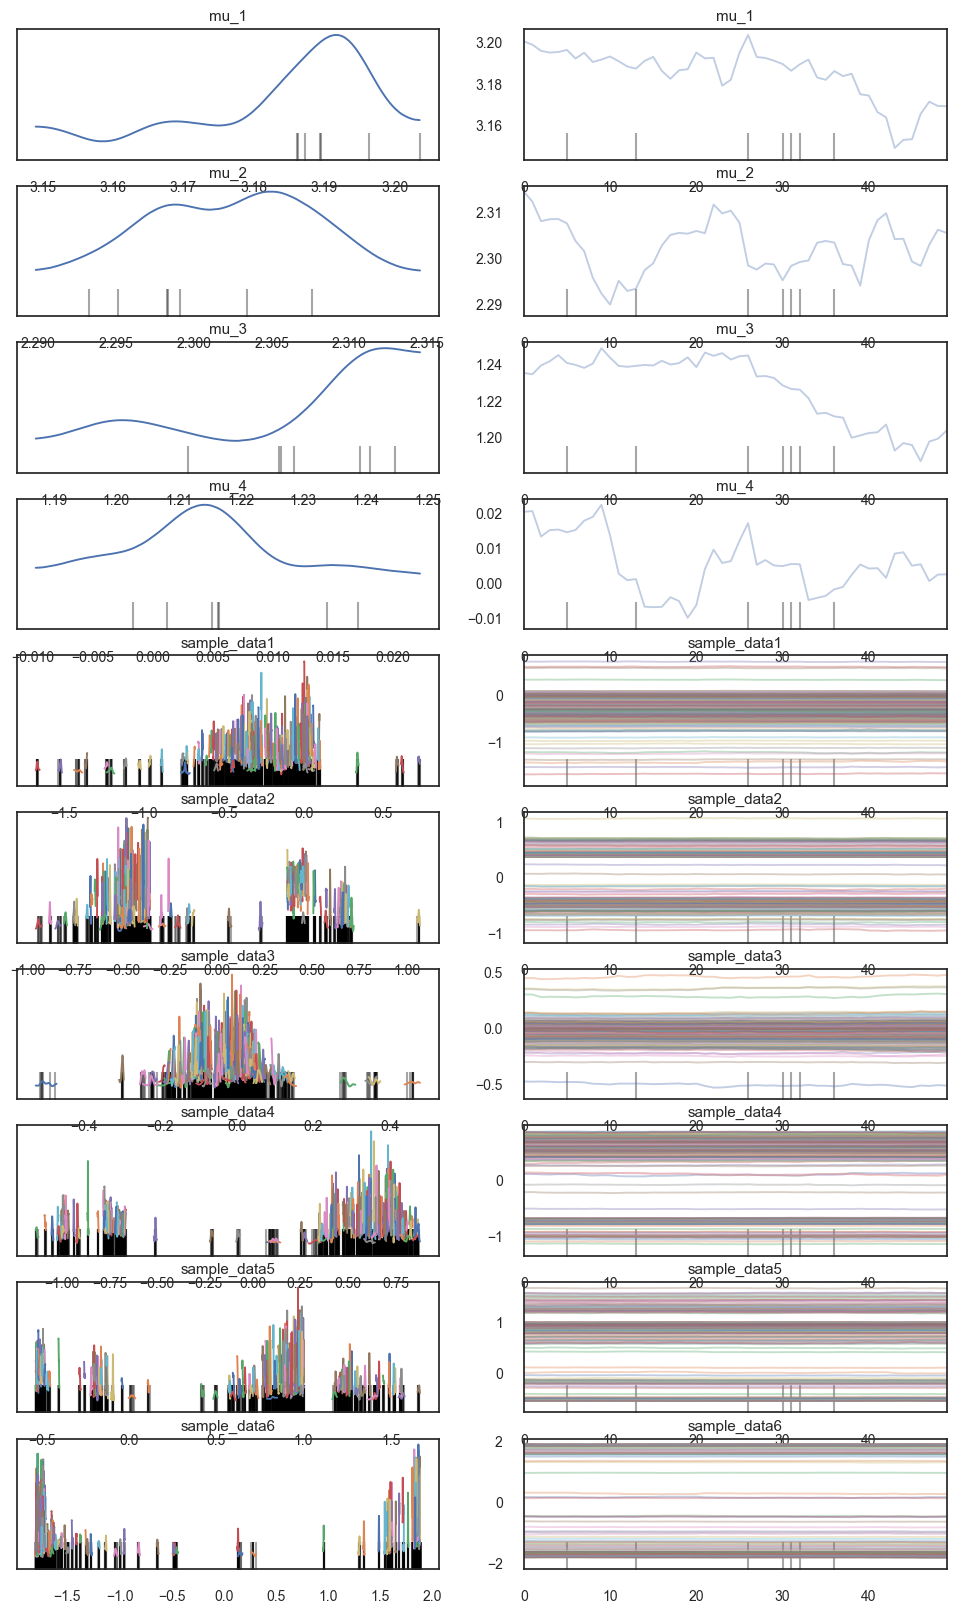

In [226]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model_test, posterior_samples)(normalised_hsi)
data = az.from_pyro(posterior=mcmc, prior=prior, posterior_predictive=posterior_predictive)
az.plot_trace(data)
plt.show()

In [227]:
posterior_samples

{'mu_1': tensor([3.2006, 3.1989, 3.1960, 3.1951, 3.1954, 3.1964, 3.1922, 3.1950, 3.1905,
         3.1917, 3.1932, 3.1909, 3.1884, 3.1873, 3.1910, 3.1931, 3.1863, 3.1824,
         3.1865, 3.1871, 3.1951, 3.1923, 3.1926, 3.1791, 3.1820, 3.1950, 3.2036,
         3.1930, 3.1925, 3.1912, 3.1896, 3.1863, 3.1894, 3.1917, 3.1831, 3.1820,
         3.1862, 3.1837, 3.1849, 3.1750, 3.1743, 3.1663, 3.1638, 3.1490, 3.1529,
         3.1532, 3.1654, 3.1713, 3.1693, 3.1692], dtype=torch.float64),
 'mu_2': tensor([2.3146, 2.3123, 2.3081, 2.3085, 2.3086, 2.3076, 2.3037, 2.3015, 2.2957,
         2.2923, 2.2898, 2.2950, 2.2928, 2.2933, 2.2974, 2.2989, 2.3028, 2.3051,
         2.3055, 2.3053, 2.3059, 2.3055, 2.3117, 2.3098, 2.3104, 2.3078, 2.2984,
         2.2975, 2.2988, 2.2986, 2.2951, 2.2983, 2.2991, 2.2995, 2.3034, 2.3038,
         2.3034, 2.2987, 2.2984, 2.2940, 2.3039, 2.3083, 2.3098, 2.3042, 2.3042,
         2.2992, 2.2983, 2.3029, 2.3062, 2.3055], dtype=torch.float64),
 'mu_3': tensor([1.2353, 1.234

In [228]:
mu_1_mean = posterior_samples["mu_1"].mean()
mu_2_mean = posterior_samples["mu_2"].mean()
mu_3_mean = posterior_samples["mu_3"].mean()
mu_4_mean = posterior_samples["mu_4"].mean()

In [229]:
# loc_mean_posterior, loc_cov_posterior =[], []
# for key, values in posterior_samples.items():
#     print(key)
#     if key == "sample_data":
#         mean = values.mean(dim=0)
#         cov = values.std(dim=0)
#         print("mean\n",mean)
#         print("cov\n", cov)
#         loc_mean_posterior.append(mean.detach().numpy())
#         loc_cov_posterior.append(cov.detach().numpy())
#     elif key == "sigma_data":
#         print("mean\n",values.mean(dim=0), "\nstd\n", values.std(dim=0))
#     else:
#         print("mean\n",values.mean(), "\nstd\n", values.std())

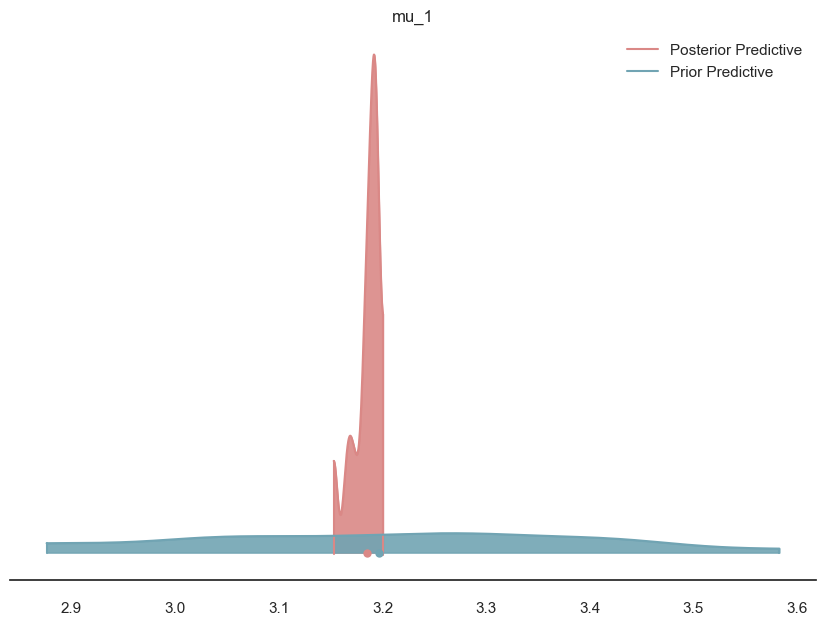

In [230]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_1'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

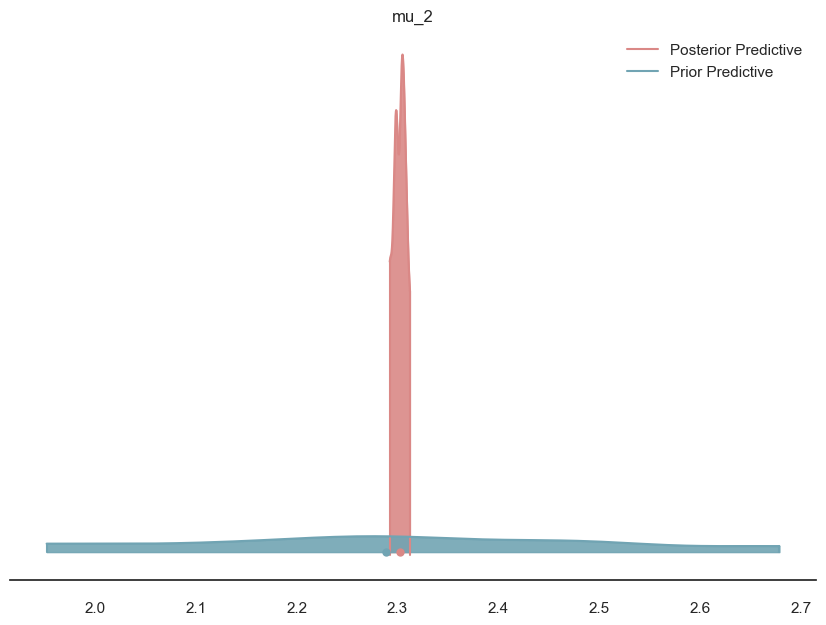

In [231]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_2'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

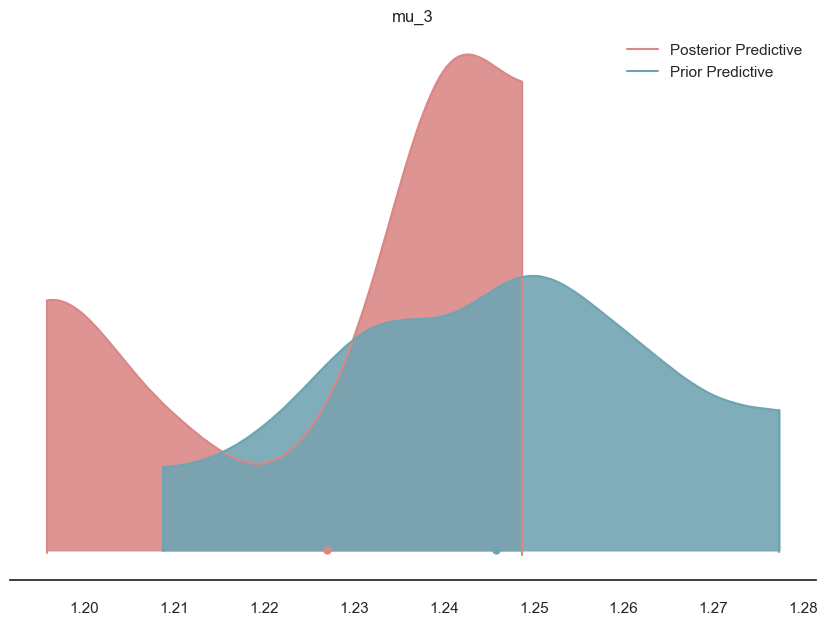

In [232]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_3'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

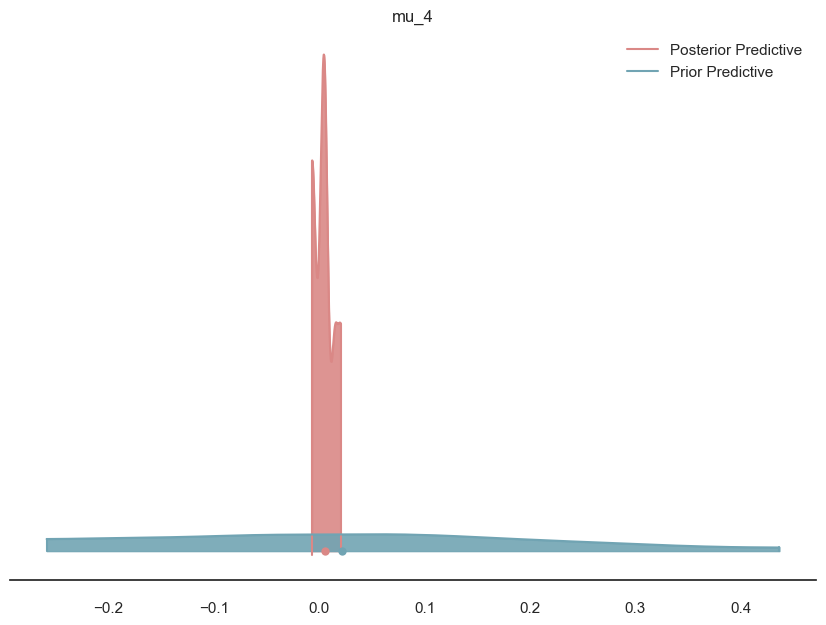

In [233]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_4'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

Condition number: 1548.4684843544323.


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


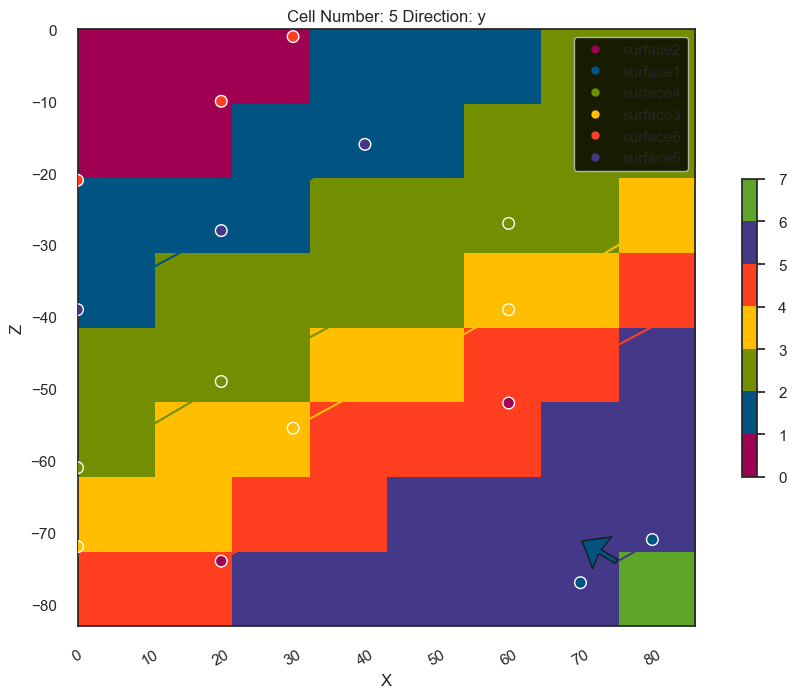

In [234]:
# # Update the model with the new top layer's location
interpolation_input = geo_model_test.interpolation_input
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([11]), torch.tensor([2])),
    posterior_samples["mu_1"].mean()
)
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([14]), torch.tensor([2])),
    posterior_samples["mu_2"].mean()
)

interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        posterior_samples["mu_3"].mean()
    )
interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([0]), torch.tensor([2])),
        posterior_samples["mu_4"].mean()
    )
    
#print("interpolation_input",interpolation_input.surface_points.sp_coords)

# # Compute the geological model
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [235]:
sp_coords_copy_test2 =interpolation_input.surface_points.sp_coords
sp_coords_copy_test2

tensor([[-2.7500,  0.0000,  0.0054],
        [-0.7500,  0.0000,  1.1000],
        [-0.2500,  0.0000, -0.1500],
        [ 0.2500,  0.0000,  0.1500],
        [-3.7500,  0.0000,  0.6500],
        [-2.7500,  0.0000,  1.2270],
        [-0.7500,  0.0000,  2.3500],
        [-3.7500,  0.0000,  0.1000],
        [-2.2500,  0.0000,  0.9250],
        [-0.7500,  0.0000,  1.7500],
        [-3.7500,  0.0000,  2.6500],
        [-2.7500,  0.0000,  3.1848],
        [-2.2500,  0.0000,  3.6500],
        [-3.7500,  0.0000,  1.7500],
        [-2.7500,  0.0000,  2.3024],
        [-1.7500,  0.0000,  2.9000]], dtype=torch.float64,
       grad_fn=<IndexPutBackward0>)

In [236]:
sp_cord= geo_model_test.transform.apply_inverse(sp_coords_copy_test2.detach().numpy())
sp_cord

array([[ 20.        ,   0.        , -73.8923812 ],
       [ 60.        ,   0.        , -52.        ],
       [ 70.        ,   0.        , -77.        ],
       [ 80.        ,   0.        , -71.        ],
       [  0.        ,   0.        , -61.        ],
       [ 20.        ,   0.        , -49.459274  ],
       [ 60.        ,   0.        , -27.        ],
       [  0.        ,   0.        , -72.        ],
       [ 30.        ,   0.        , -55.5       ],
       [ 60.        ,   0.        , -39.        ],
       [  0.        ,   0.        , -21.        ],
       [ 20.        ,   0.        , -10.30359735],
       [ 30.        ,   0.        ,  -1.        ],
       [  0.        ,   0.        , -39.        ],
       [ 20.        ,   0.        , -27.95224016],
       [ 40.        ,   0.        , -16.        ]])

Active grids: ['custom']
Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


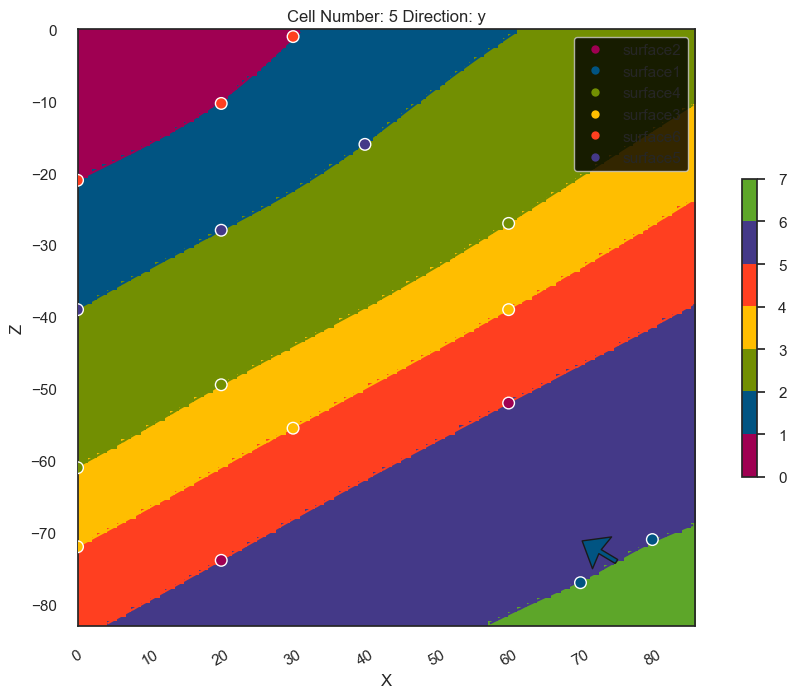

In [237]:
geo_model_test_post = gp.create_geomodel(
    project_name='Gempy_abc_Test_post',
    extent=[0, 86, -10, 10, -83, 0],
    resolution=[86,20,83],
    refinement=7,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )

gp.add_surface_points(
    geo_model=geo_model_test_post,
    x=[70.0, 80.0],
    y=[0.0, 0.0],
    z=[-77.0, -71.0],
    elements_names=['surface1', 'surface1']
)

gp.add_orientations(
    geo_model=geo_model_test_post,
    x=[75],
    y=[0.0],
    z=[-74],
    elements_names=['surface1'],
    pole_vector=[[-5/3, 0, 1]]
)
geo_model_test_post.update_transform(gp.data.GlobalAnisotropy.NONE)

element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([20.0, 60.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([sp_cord[0,2], -52]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element2)

element3 = gp.data.StructuralElement(
    name='surface3',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 30.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-72, -55.5, -39]),
        names='surface3'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element3)

element4 = gp.data.StructuralElement(
    name='surface4',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-61, sp_cord[5,2], -27]),
        names='surface4'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element4)

element5 = gp.data.StructuralElement(
    name='surface5',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20, 40]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-39, sp_cord[14,2], -16]),
        names='surface5'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element5)

element6 = gp.data.StructuralElement(
    name='surface6',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0,30]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-21, sp_cord[11,2], -1]),
        names='surface6'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element6)

geo_model_test_post.structural_frame.structural_groups[0].elements[0], geo_model_test_post.structural_frame.structural_groups[0].elements[1],\
geo_model_test_post.structural_frame.structural_groups[0].elements[2], geo_model_test_post.structural_frame.structural_groups[0].elements[3],\
geo_model_test_post.structural_frame.structural_groups[0].elements[4], geo_model_test_post.structural_frame.structural_groups[0].elements[5] = \
geo_model_test_post.structural_frame.structural_groups[0].elements[1], geo_model_test_post.structural_frame.structural_groups[0].elements[0],\
geo_model_test_post.structural_frame.structural_groups[0].elements[3], geo_model_test_post.structural_frame.structural_groups[0].elements[2],\
geo_model_test_post.structural_frame.structural_groups[0].elements[5], geo_model_test_post.structural_frame.structural_groups[0].elements[4]  


gp.set_custom_grid(geo_model_test_post.grid, xyz_coord=xyz_coord)
gp.compute_model(geo_model_test_post)
gpv.plot_2d(geo_model_test_post, cell_number=5, legend='force')


In [238]:
custom_grid_values_post = geo_model_test_post.solutions.octrees_output[0].last_output_center.custom_grid_values

In [239]:
custom_grid_values_post

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 6., 6., 6., 6., 6.])

In [240]:
y_obs_label

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        6., 6., 6., 6., 6.], dtype=torch.float64)

In [241]:
torch.tensor(custom_grid_values_post, dtype=torch.float64) - y_obs_label

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)